# Estimar esforço em desenvolvimento de software com redes neurais profundas

Desenvolvimento do Trabalho de Graduação


## Dependências

- Python 3.6
- numpy >= 1.15.4
- pandas >= 0.23.4
- matplotlib >= 2.2.3
- statsmodel >= 0.9.0
- seaborn >= 0.9.0

In [1]:
import math
from glob import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

import keras


sns.set()

Using Theano backend.


## Constantes globais de configurações

In [2]:
caminho_dados = 'dados/cocomo/'
caminho_dados_afp = 'dados/pontos-funcao/'
dim_inicial = 3
dim_intermediaria = 2

validacao = 0.3
teste = 0.3

## Carregamento e pre-processamento dos dados

In [3]:
def carregar_tudo(caminho_dados):
    dados = {}
    for arquivo in glob(caminho_dados+'/*.csv'):
        ticker = arquivo.split('/')[-1].split('.')[0]
        tabela = pd.read_csv(arquivo, skipinitialspace=True)
        dados[ticker] = tabela
    return dados

dados = carregar_tudo(caminho_dados)
dados.keys()

dict_keys(['cocomo_nasa2', 'cocomo_sdr', 'cocomo_nasa2000', 'cocomo81', 'cocomo_nasa'])

In [4]:
dados['cocomo81'].head()

ID PREC FLEX RESL TEAM PMAT RELY DATA CPLX RUSE  ...   APEX PLEX LTEX TOOL  \
0   1    h    h    h   vh   vl    l   vh   vl    n  ...      l    l    n   vl   
1   2    h    h    h   vh   vl    l   vh    l    n  ...      h    h    h   vl   
2   3    h    h    h   vh    n    n   vh    l    n  ...     vh    h    h    l   
3   4    h    h    h   vh   vl   vl   vh   vl    n  ...      h    n    h   vl   
4   5    h    h    h   vh   vl    l    l    n    n  ...      n    h    h   vl   

  SITE SCED   KLOC  Effort Defects Months  
0    h    n  113.0  2040.0   13027   38.4  
1    h    n  293.0  1600.0   25229   48.6  
2    h    n  132.0   243.0    3694   28.7  
3    h    n   60.0   240.0    5688   28.0  
4    h    n   16.0    33.0     970   14.3  

[5 rows x 27 columns]

In [5]:
dados['cocomo_nasa'].head()

RELY DATA CPLX TIME STOR VIRT TURN ACAP AEXP PCAP VEXP LEXP MODP TOOL SCED  \
0    n    h   vh    n    n    l    n    h    n   vh    l    n    h    n    l   
1   vh    h    h   vh   vh    n    n   vh   vh   vh    n    h    h    h    l   
2    n    h    h   vh    h    l    h    h    n    h    l    h    h    n    l   
3    h    l    h    n    n    l    l    n    n    n    n    h    h    n    l   
4    h    l    h    n    n    l    l    n    n    n    n    h    h    n    l   

    KLOC  Effort  
0   70.0   278.0  
1  227.0  1181.0  
2  177.9  1248.0  
3  115.8   480.0  
4   29.5   120.0

In [6]:
dados['cocomo_nasa2'].head()

ID projectname                cat2 forg  center  year          mode RELY  \
0   1          de  avionicsmonitoring    g       2  1979  semidetached    h   
1   2          de  avionicsmonitoring    g       2  1979  semidetached    h   
2   3          de  avionicsmonitoring    g       2  1979  semidetached    h   
3   4          de  avionicsmonitoring    g       2  1979  semidetached    h   
4   5          de  avionicsmonitoring    g       2  1979  semidetached    h   

  DATA CPLX  ...   ACAP AEXP PCAP VEXP LEXP MODP TOOL SCED  KLOC Effort  
0    l    h  ...      n    n    n    n    h    h    n    l  25.9  117.6  
1    l    h  ...      n    n    n    n    h    h    n    l  24.6  117.6  
2    l    h  ...      n    n    n    n    h    h    n    l   7.7   31.2  
3    l    h  ...      n    n    n    n    h    h    n    l   8.2   36.0  
4    l    h  ...      n    n    n    n    h    h    n    l   9.7   25.2  

[5 rows x 24 columns]

In [7]:
dados['cocomo_sdr']

ID PREC FLEX RESL TEAM PMAT RELY DATA CPLX RUSE  ...   PCAP PCON APEX  \
0    1   vh    n    l    h   vl    n    n    l    l  ...     vh   vh   vh   
1    2   vh    n    l   vh   vl    h    n    l    n  ...      h   vh   vh   
2    3   xh    n    l    h   vl    h   vh    l    n  ...      h   vh   vh   
3    4   xh    h    h    h    n    h    h   vh    l  ...      h   vl    h   
4    5    n    n    l    h    n    l    n   vh    n  ...      h    h    n   
5    6   vh    l   xh   xh    h    l    l    n    l  ...     vh    h    n   
6    7   xh   vh   xh    n    h    l    l    l    n  ...     vh   vh    n   
7    8    n   vl   vh    n    l    l   vh   vl    h  ...      h   vh    n   
8    9   vl   vl    n   vl    l   vl    n    l   vh  ...      h   vh    h   
9   10    n   vl   vh    l    l   vl    h    n   vh  ...     vh   vh    h   
10  11    h    n   vh    h    l    l    n    n    n  ...      h   vh    n   
11  12    l    n    n    h    n    l    l    h    h  ...      h   vh    h   

   PLEX LTEX TOOL SITE SCED     KLOC Effort  
0     h    h    h    l    n    3.000    1.2  
1    vh   vh    h   vl    h    2.000    2.0  
2    vh   vh    h   vl    h    4.250    4.5  
3    vh    h    n    h    h   10.000    3.0  
4     n    n    n    h    l   15.000    4.0  
5     h    h   vl   xh    l   40.530   22.0  
6    vh   vh   vl    h    l    4.050    2.0  
7     n    n    n   vh    n   31.845    5.0  
8     h    h    n    h    n  114.280   18.0  
9    vh    h    n    n    l   23.106    4.0  
10    n    h   vh   vh    h    1.369    1.0  
11    n    h   vh   vh    h    1.611    2.1  

[12 rows x 25 columns]

In [8]:
# nasa2000 = dados['cocomo_nasa2000'][params.index] # OLD
# for nome, valores in params[params.columns[1:]].iterrows():
#     novo = nasa2000.astype({nome: 'object'})
#     for categoria, valor in valores.iteritems():
#         novo.loc[abs(nasa2000.loc[:, nome] - valor) < 0.001, nome] = categoria.lower()
#     nasa2000 = novo
# for coluna in nasa2000.columns:
#     dados['cocomo_nasa2000'] = dados['cocomo_nasa2000'].astype({coluna: 'object'})
#     dados['cocomo_nasa2000'].loc[:, coluna] = nasa2000.loc[:, coluna]
# cheios = nasa2000.isin([a.lower() for a in params.columns[1:]]).sum(axis=1)==nasa2000.shape[1]
# nasa2000limpa=dados['cocomo_nasa2000'].loc[cheios,:]
# nasa2000limpa.to_csv('cocomo_nasa2000l.csv', index=False)
dados['cocomo_nasa2000'].head()

ID Unusual Flag  Nasa60? ProjectID PARENT ELEMENT             Category  \
0  1            0        1         A   AGSA     ADS  Avionics Monitoring   
1  2            0        1         A   AGSB     ADS  Avionics Monitoring   
2  3            0        1         A   AGSB     DAD  Avionics Monitoring   
3  4            0        1         A     DE     ATD  Avionics Monitoring   
4  5            0        1         A     DE     C&P  Avionics Monitoring   

  F or G  Center  Start Year  ...  End Date  Delivered Logical KLOC  \
0      G       2        1979  ...   7/18/81                   29.70   
1      G       2        1979  ...   7/18/81                   27.99   
2      G       2        1979  ...   7/18/81                    8.55   
3      G       2        1979  ...   7/18/81                    7.56   
4      G       2        1979  ...   7/18/81                    9.54   

   Physical Delivered KLOC  Ported KLOC  %DM  %CM  %IM Actual Schedule  \
0                     33.0            0  0.0  0.0  0.0               0   
1                     31.1            0  0.0  0.0  0.0               0   
2                      9.5            0  0.0  0.0  0.0               0   
3                      8.4            0  0.0  0.0  0.0               0   
4                     10.6            0  0.0  0.0  0.0               0   

  productivity per day  KLOC  
0             9.910714  25.9  
1             9.413265  24.6  
2            11.105769   7.7  
3            10.250000   8.2  
4            17.321429   9.7  

[5 rows x 50 columns]

In [4]:
def sufixo_K(x, pos):
    return '%dK' % x

def visualiza_dados(tabelas, nome, params):
    tabela = tabelas[nome]
    classes = [a.lower() for a in params.columns[1:]]
    em_texto = tabela.loc[:, params.index.values].values
    heatmap = np.zeros((len(params.index), len(params.columns[1:])), dtype='int32')
    for i, k in enumerate(params.index):
        for no, classe in enumerate(classes):
            heatmap[i, no] = np.sum(em_texto[:,i] == classe)
    gs = matplotlib.gridspec.GridSpec(2, 2)
    figura = plt.figure(figsize=(12,10), dpi=200)

    ax = plt.subplot(gs[:, 1])
    sns.heatmap(heatmap, annot=True, ax = ax, fmt='d')
    #ax.set_xlabel('Ponderações das classes');ax.set_ylabel('Parâmetros do modelo')
    ax.set_title('Distribuição das classes de entrada')
    ax.xaxis.set_ticklabels(params.columns[1:].values); ax.yaxis.set_ticklabels(params.index.values)
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    ax = plt.subplot(gs[0, 0])
    tabela.Effort.hist(bins=60, normed=True)
    tabela.Effort.dropna().plot(kind='kde', xlim=(0,tabela.Effort.max()), style='r--')
    plt.xlabel("Esforço (homens-mês)")
    plt.ylabel("Frequência Normalizada")
    
    ax = plt.subplot(gs[1, 0])
    formato_K = matplotlib.ticker.FuncFormatter(sufixo_K)
    ax.xaxis.set_major_formatter(formato_K)
    tabela.KLOC.hist(bins=60, normed=True)
    tabela.KLOC.dropna().plot(kind='kde', xlim=(0,tabela.KLOC.max()), style='r--')
    plt.xlabel("Linhas de Código")
    plt.ylabel("Frequência Normalizada")
    
    #figura.savefig("resultados/dados/"+nome+".pdf", bbox_inches='tight')

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


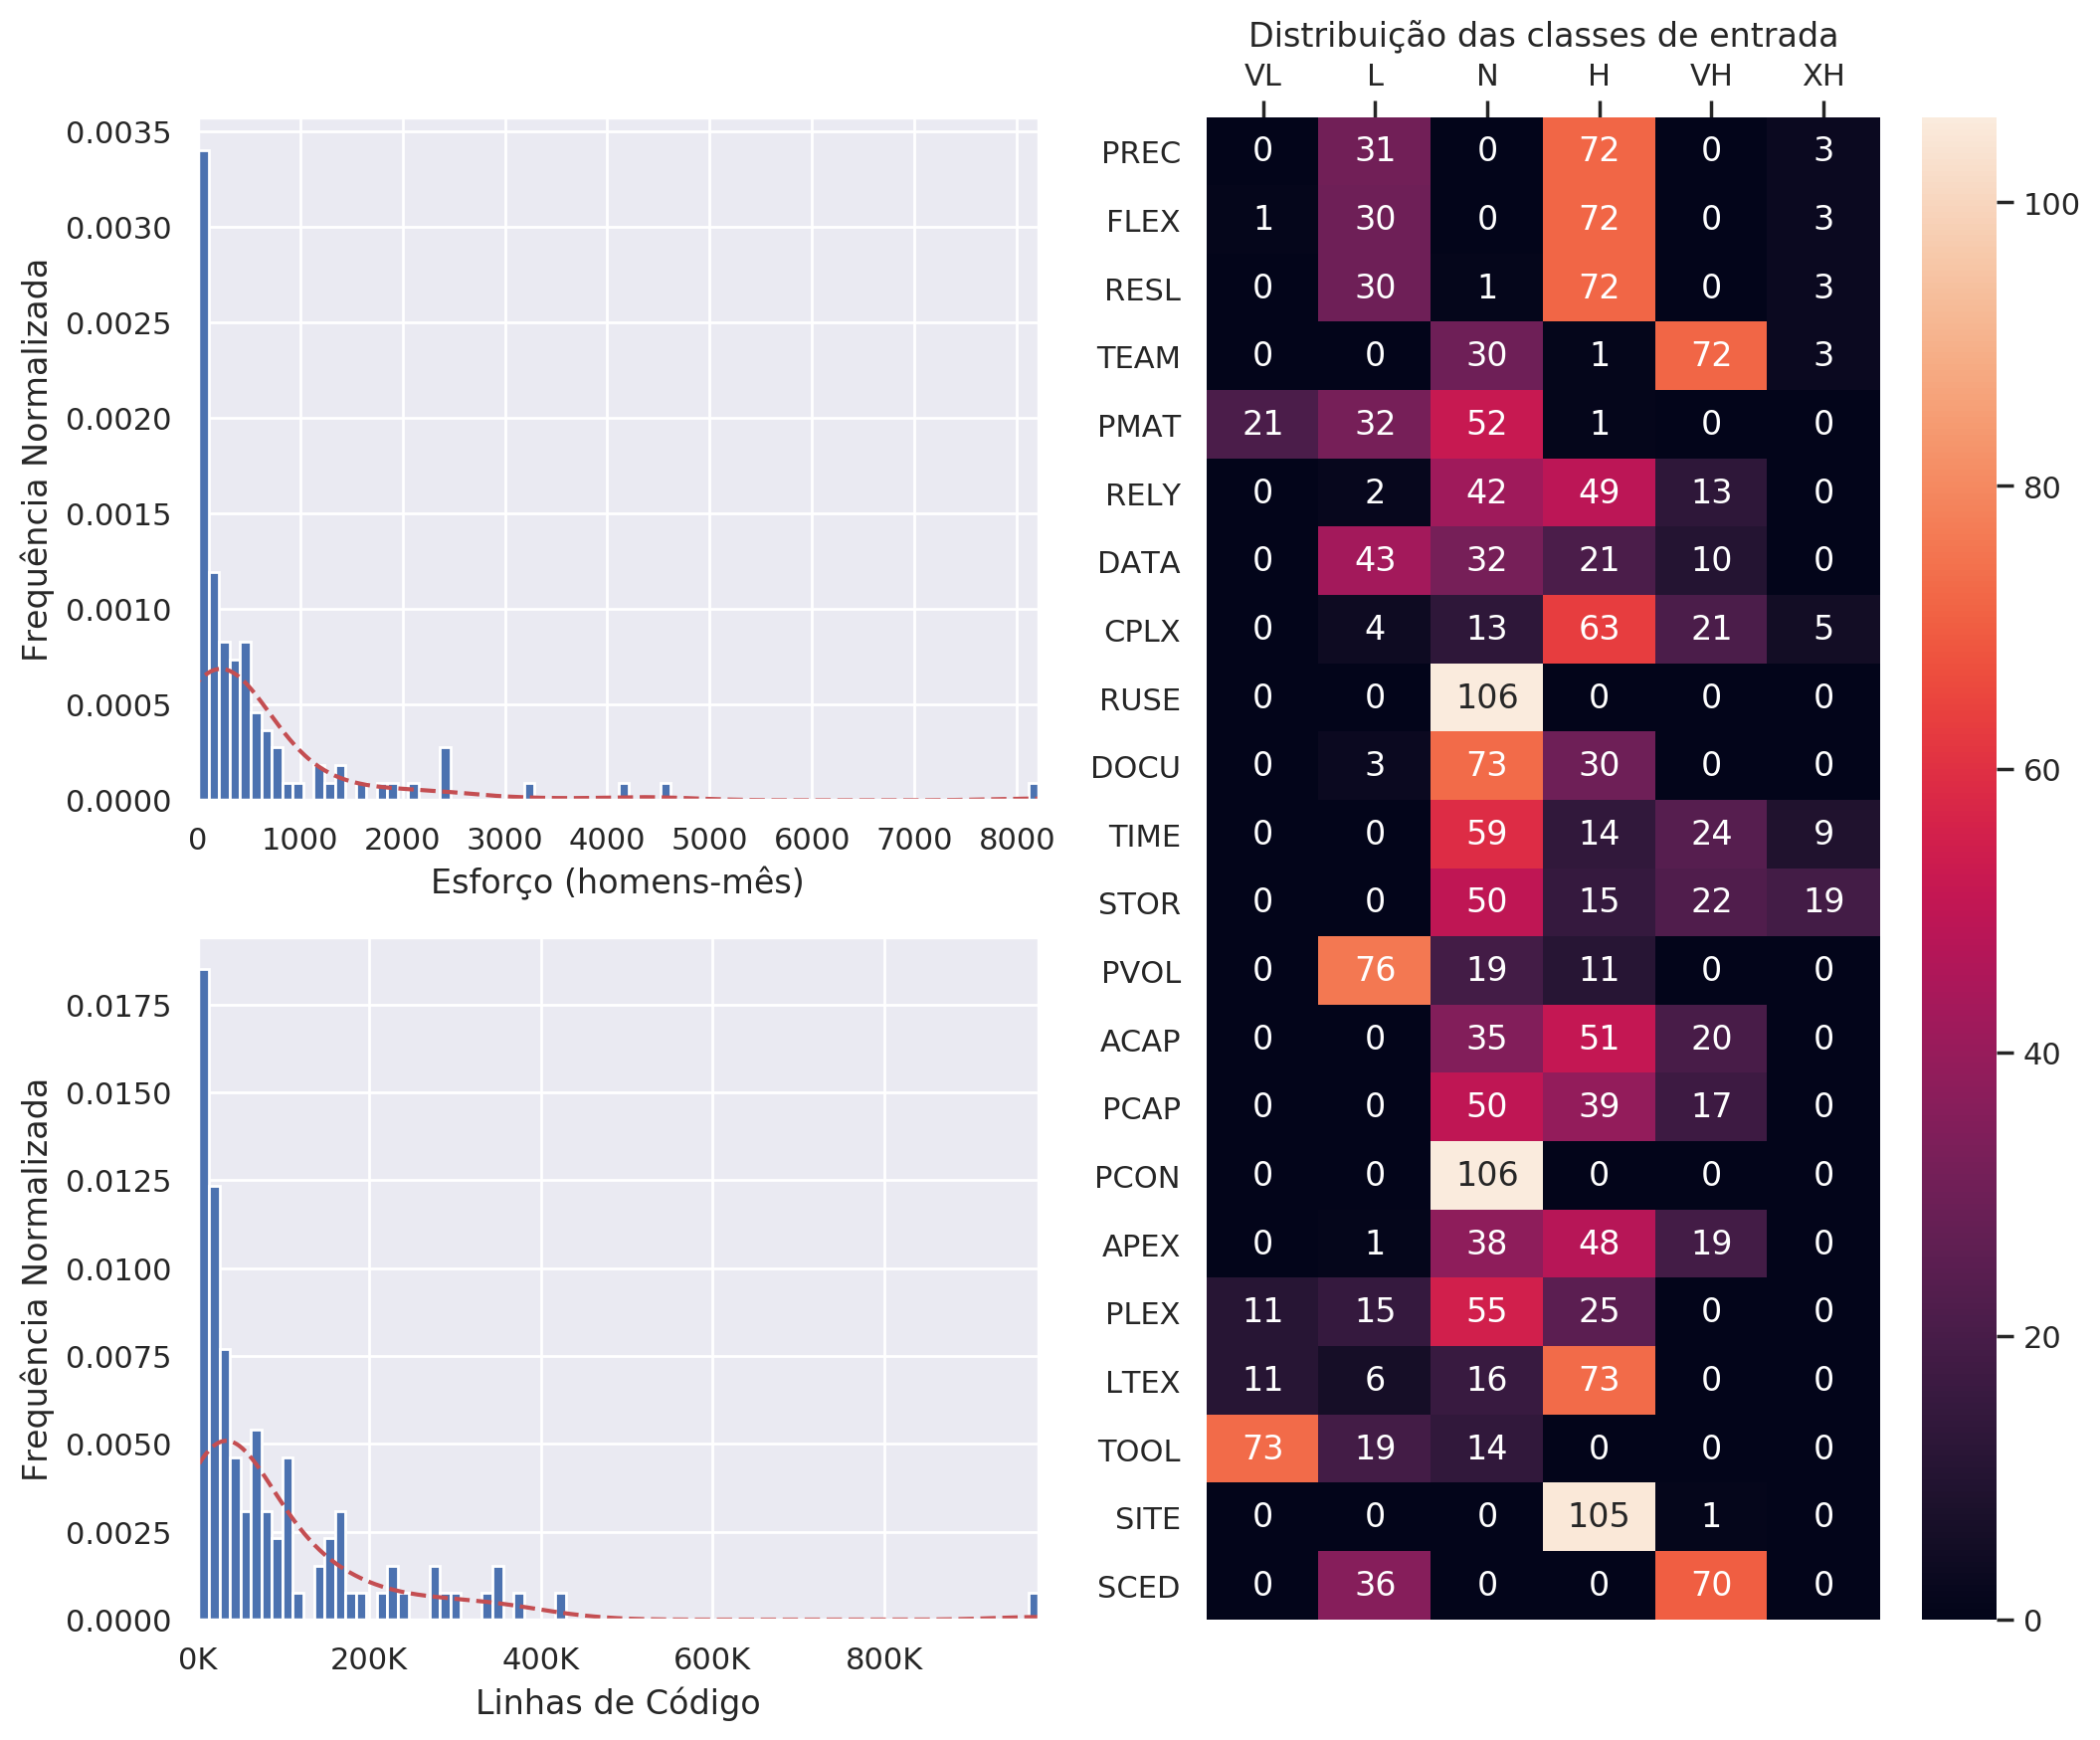

In [834]:
visualiza_dados(dados, 'cocomo_nasa2000', params)

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


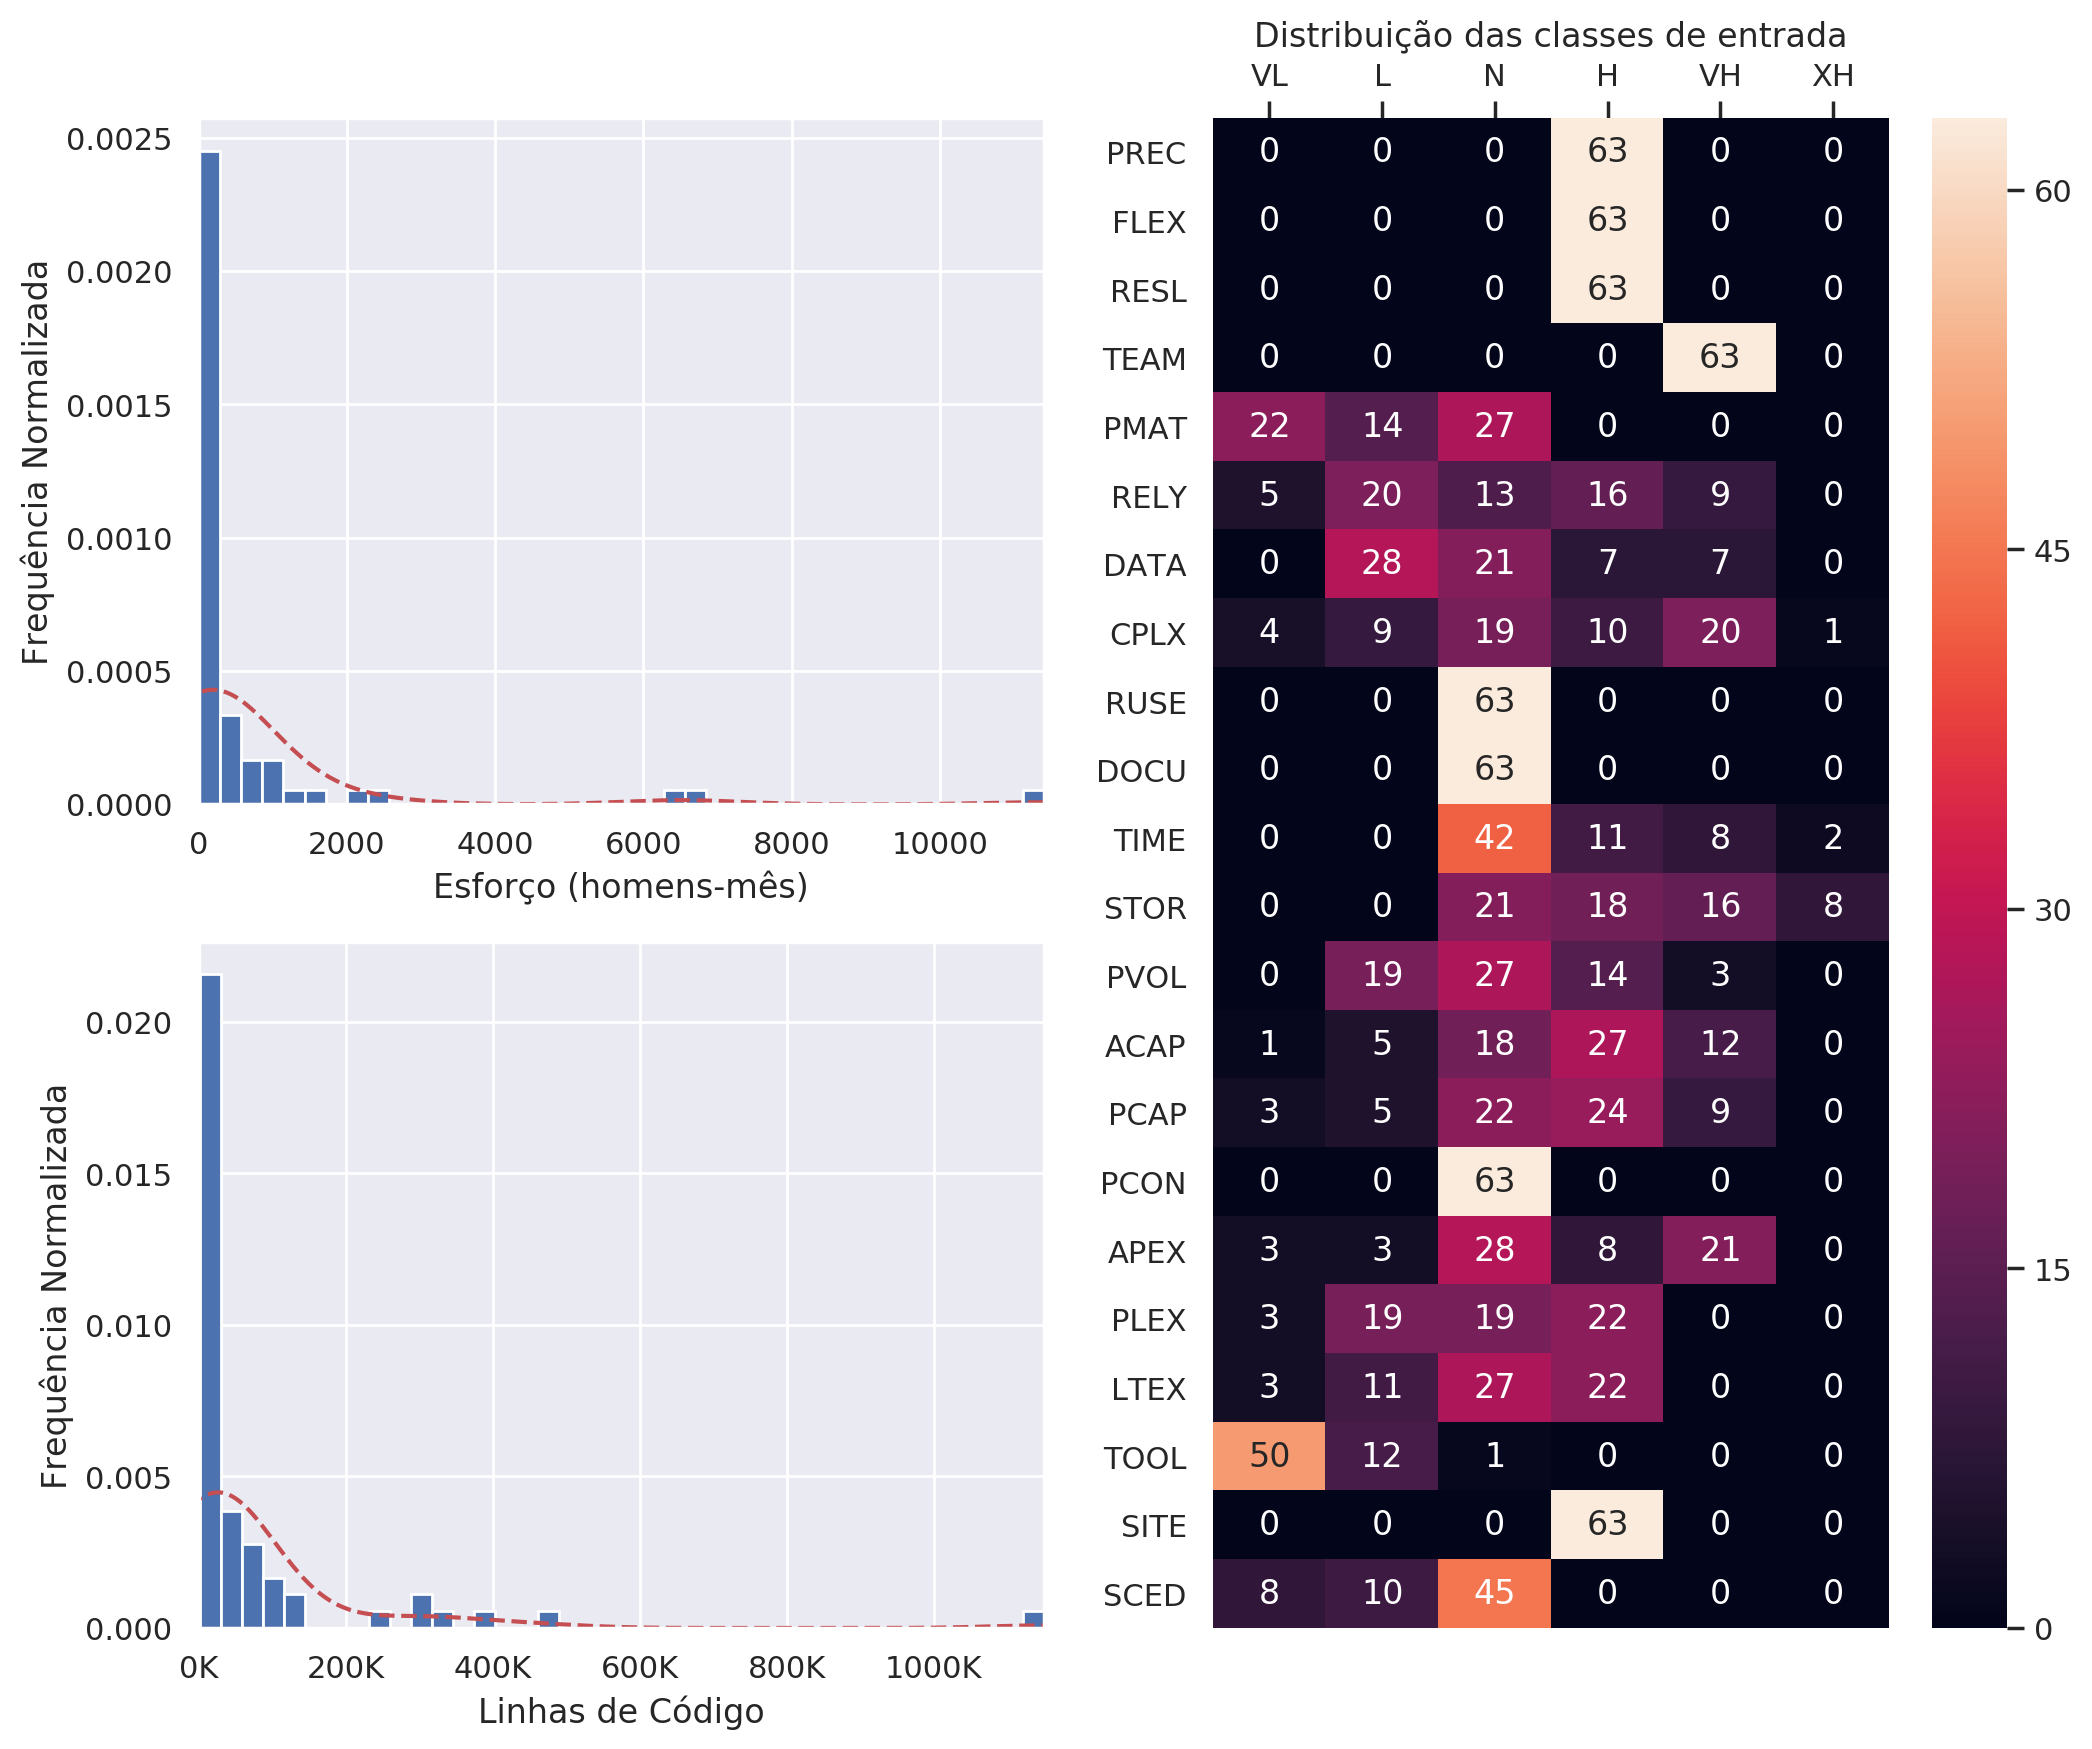

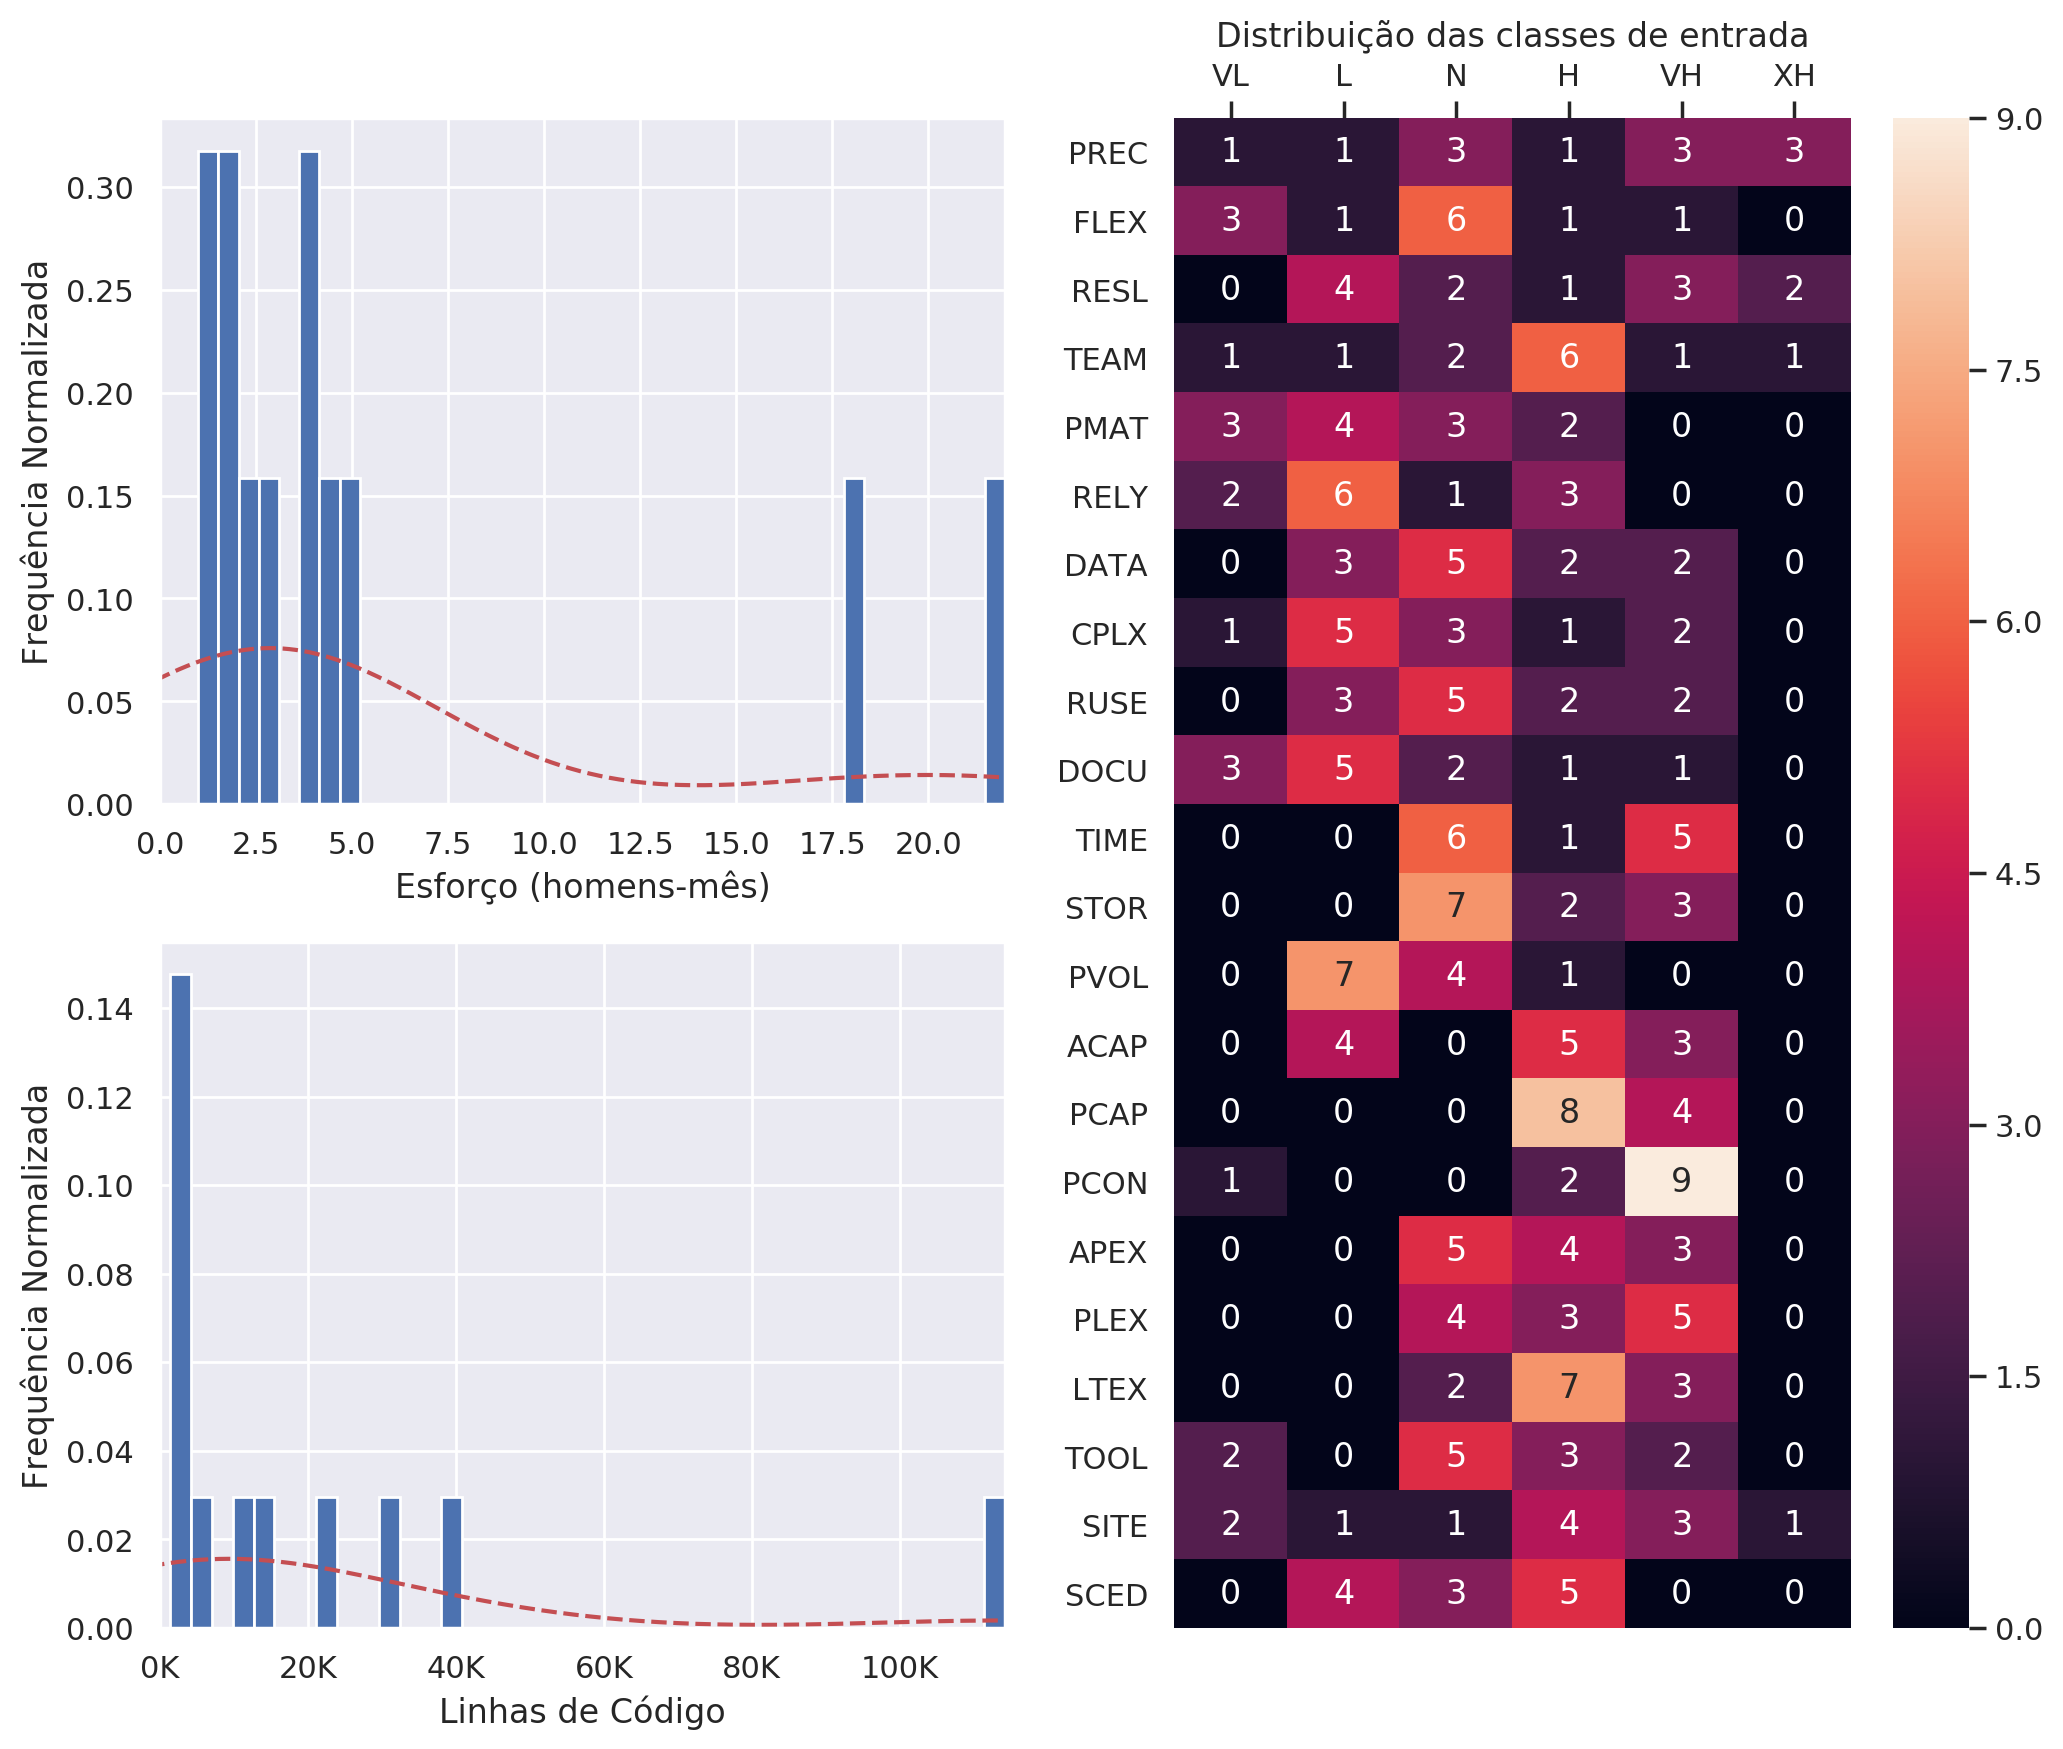

In [793]:
visualiza_dados(dados, 'cocomo81', params)
visualiza_dados(dados, 'cocomo_sdr', params)

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


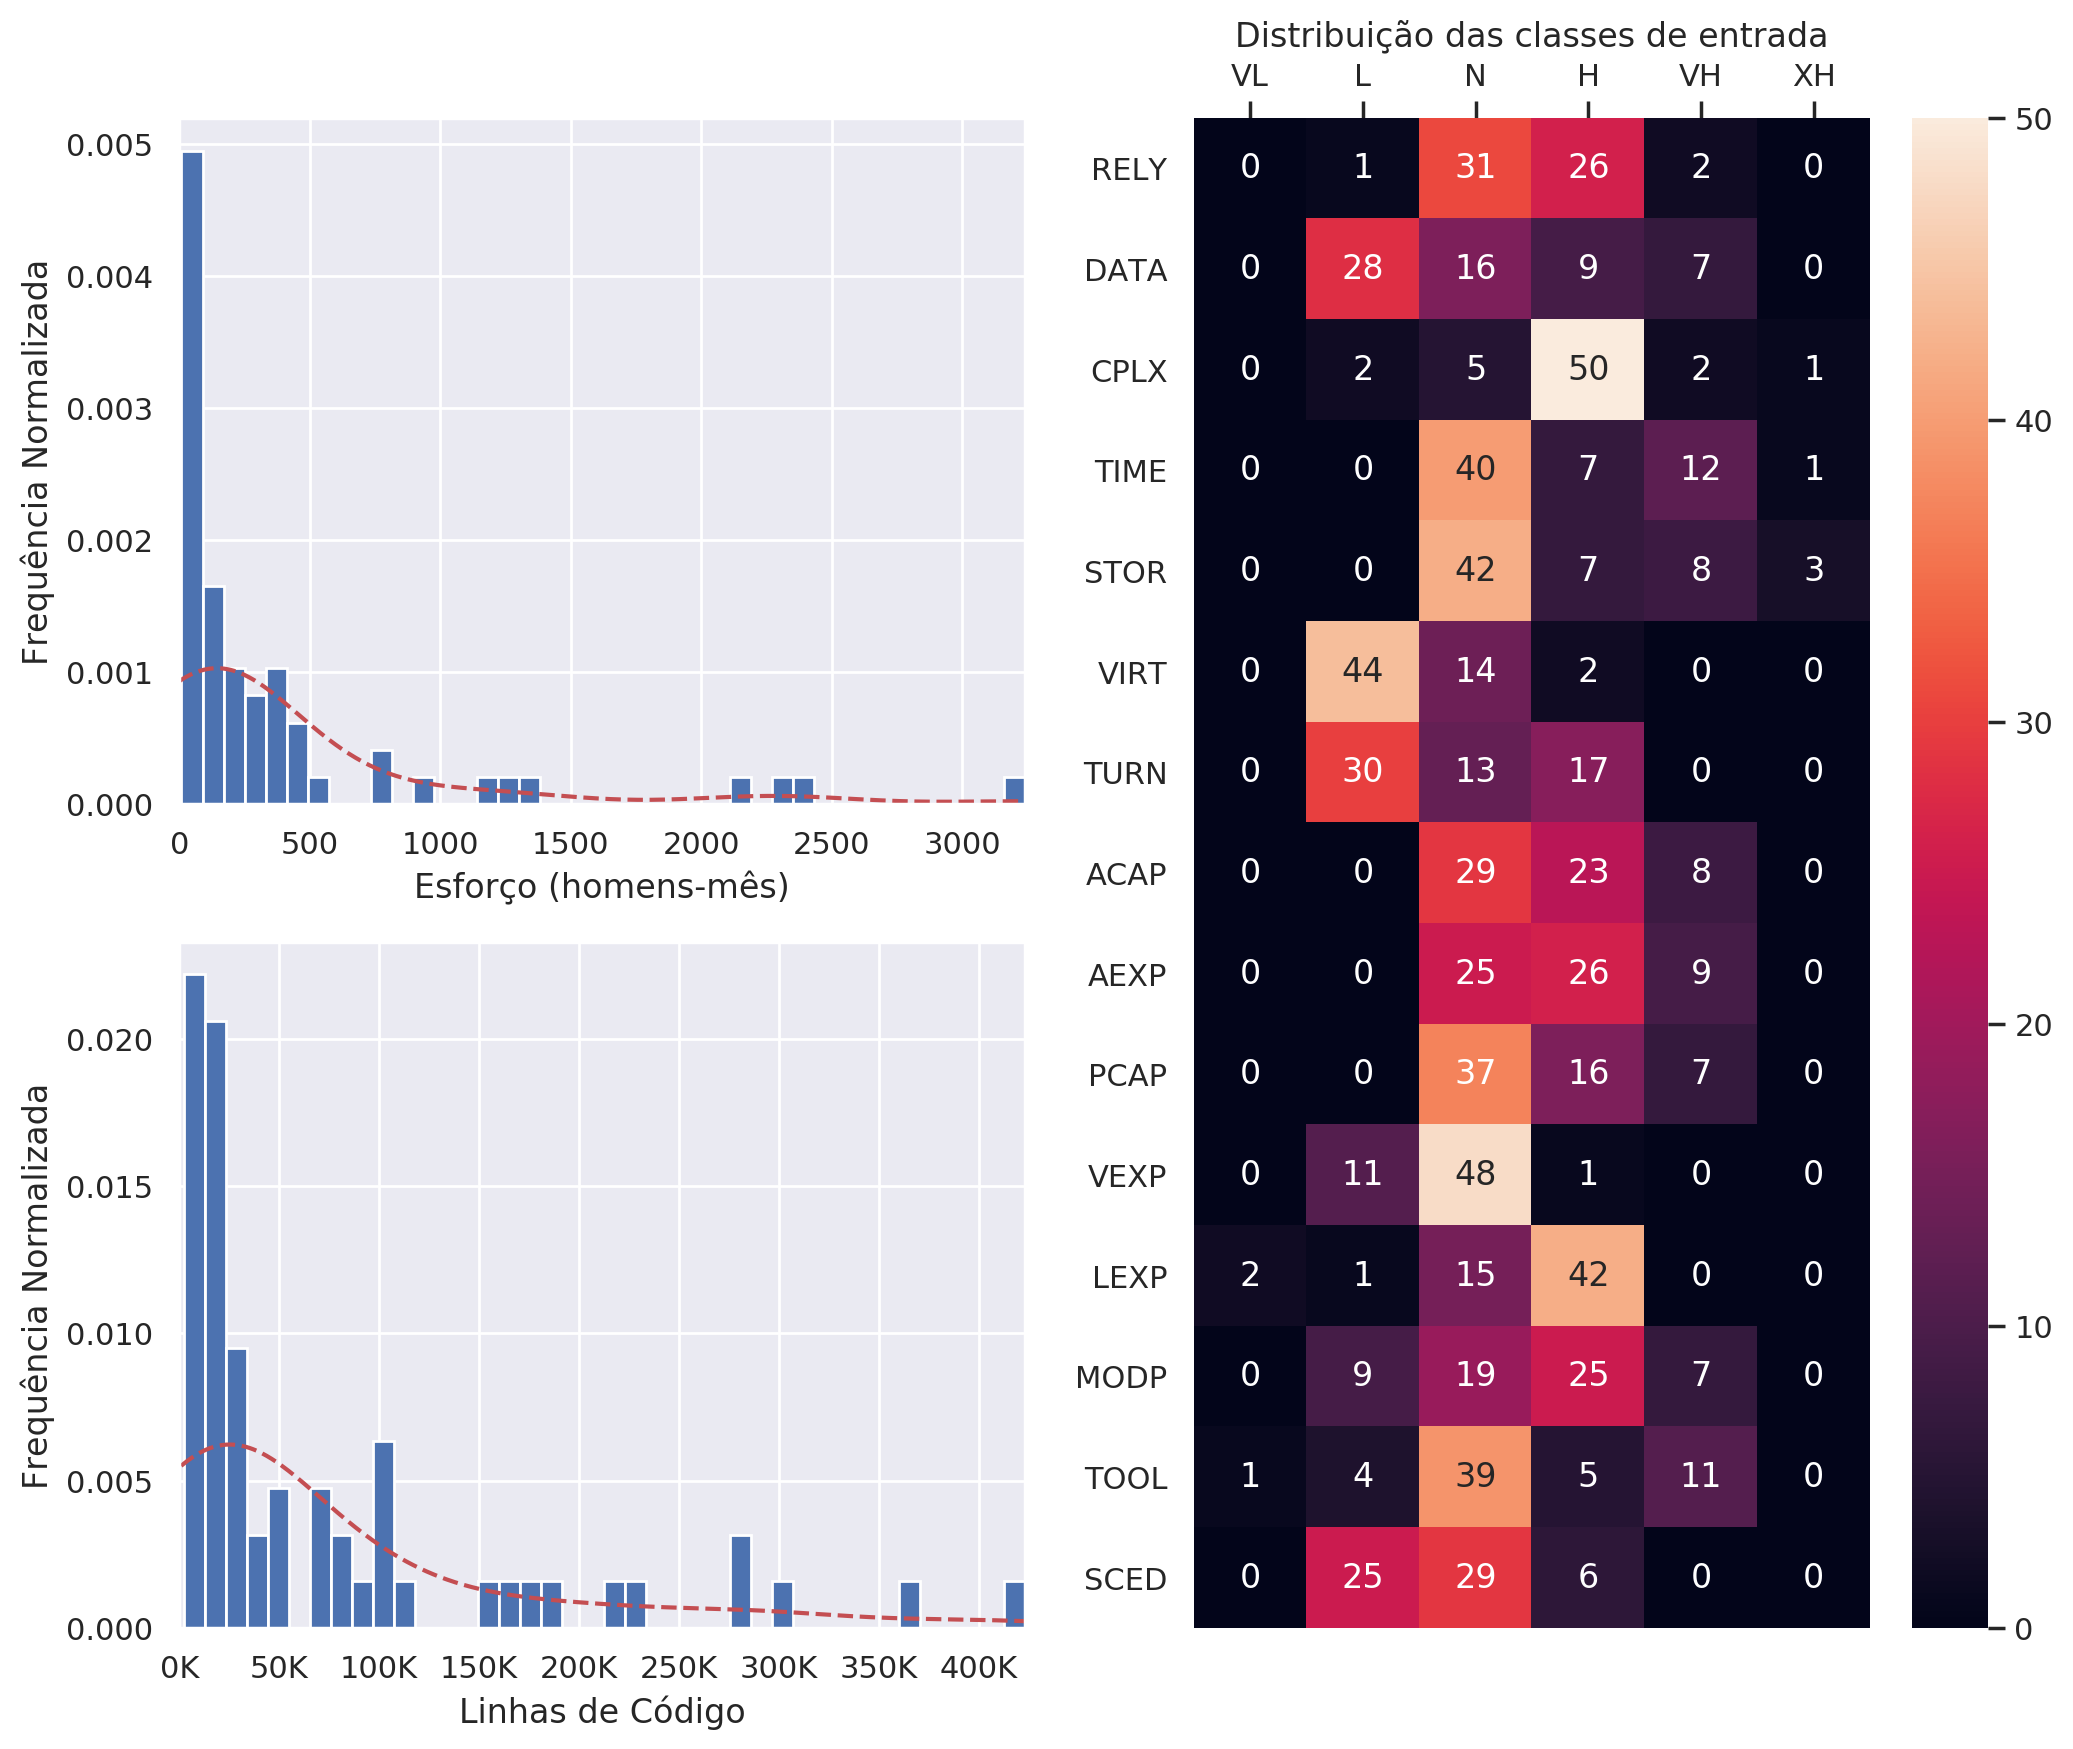

In [823]:
parametros_vazios = pd.DataFrame(columns=params.columns, data=[[0]*len(params.columns)]*15, index=dados['cocomo_nasa'].columns[:15])
visualiza_dados(dados, 'cocomo_nasa', parametros_vazios)

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


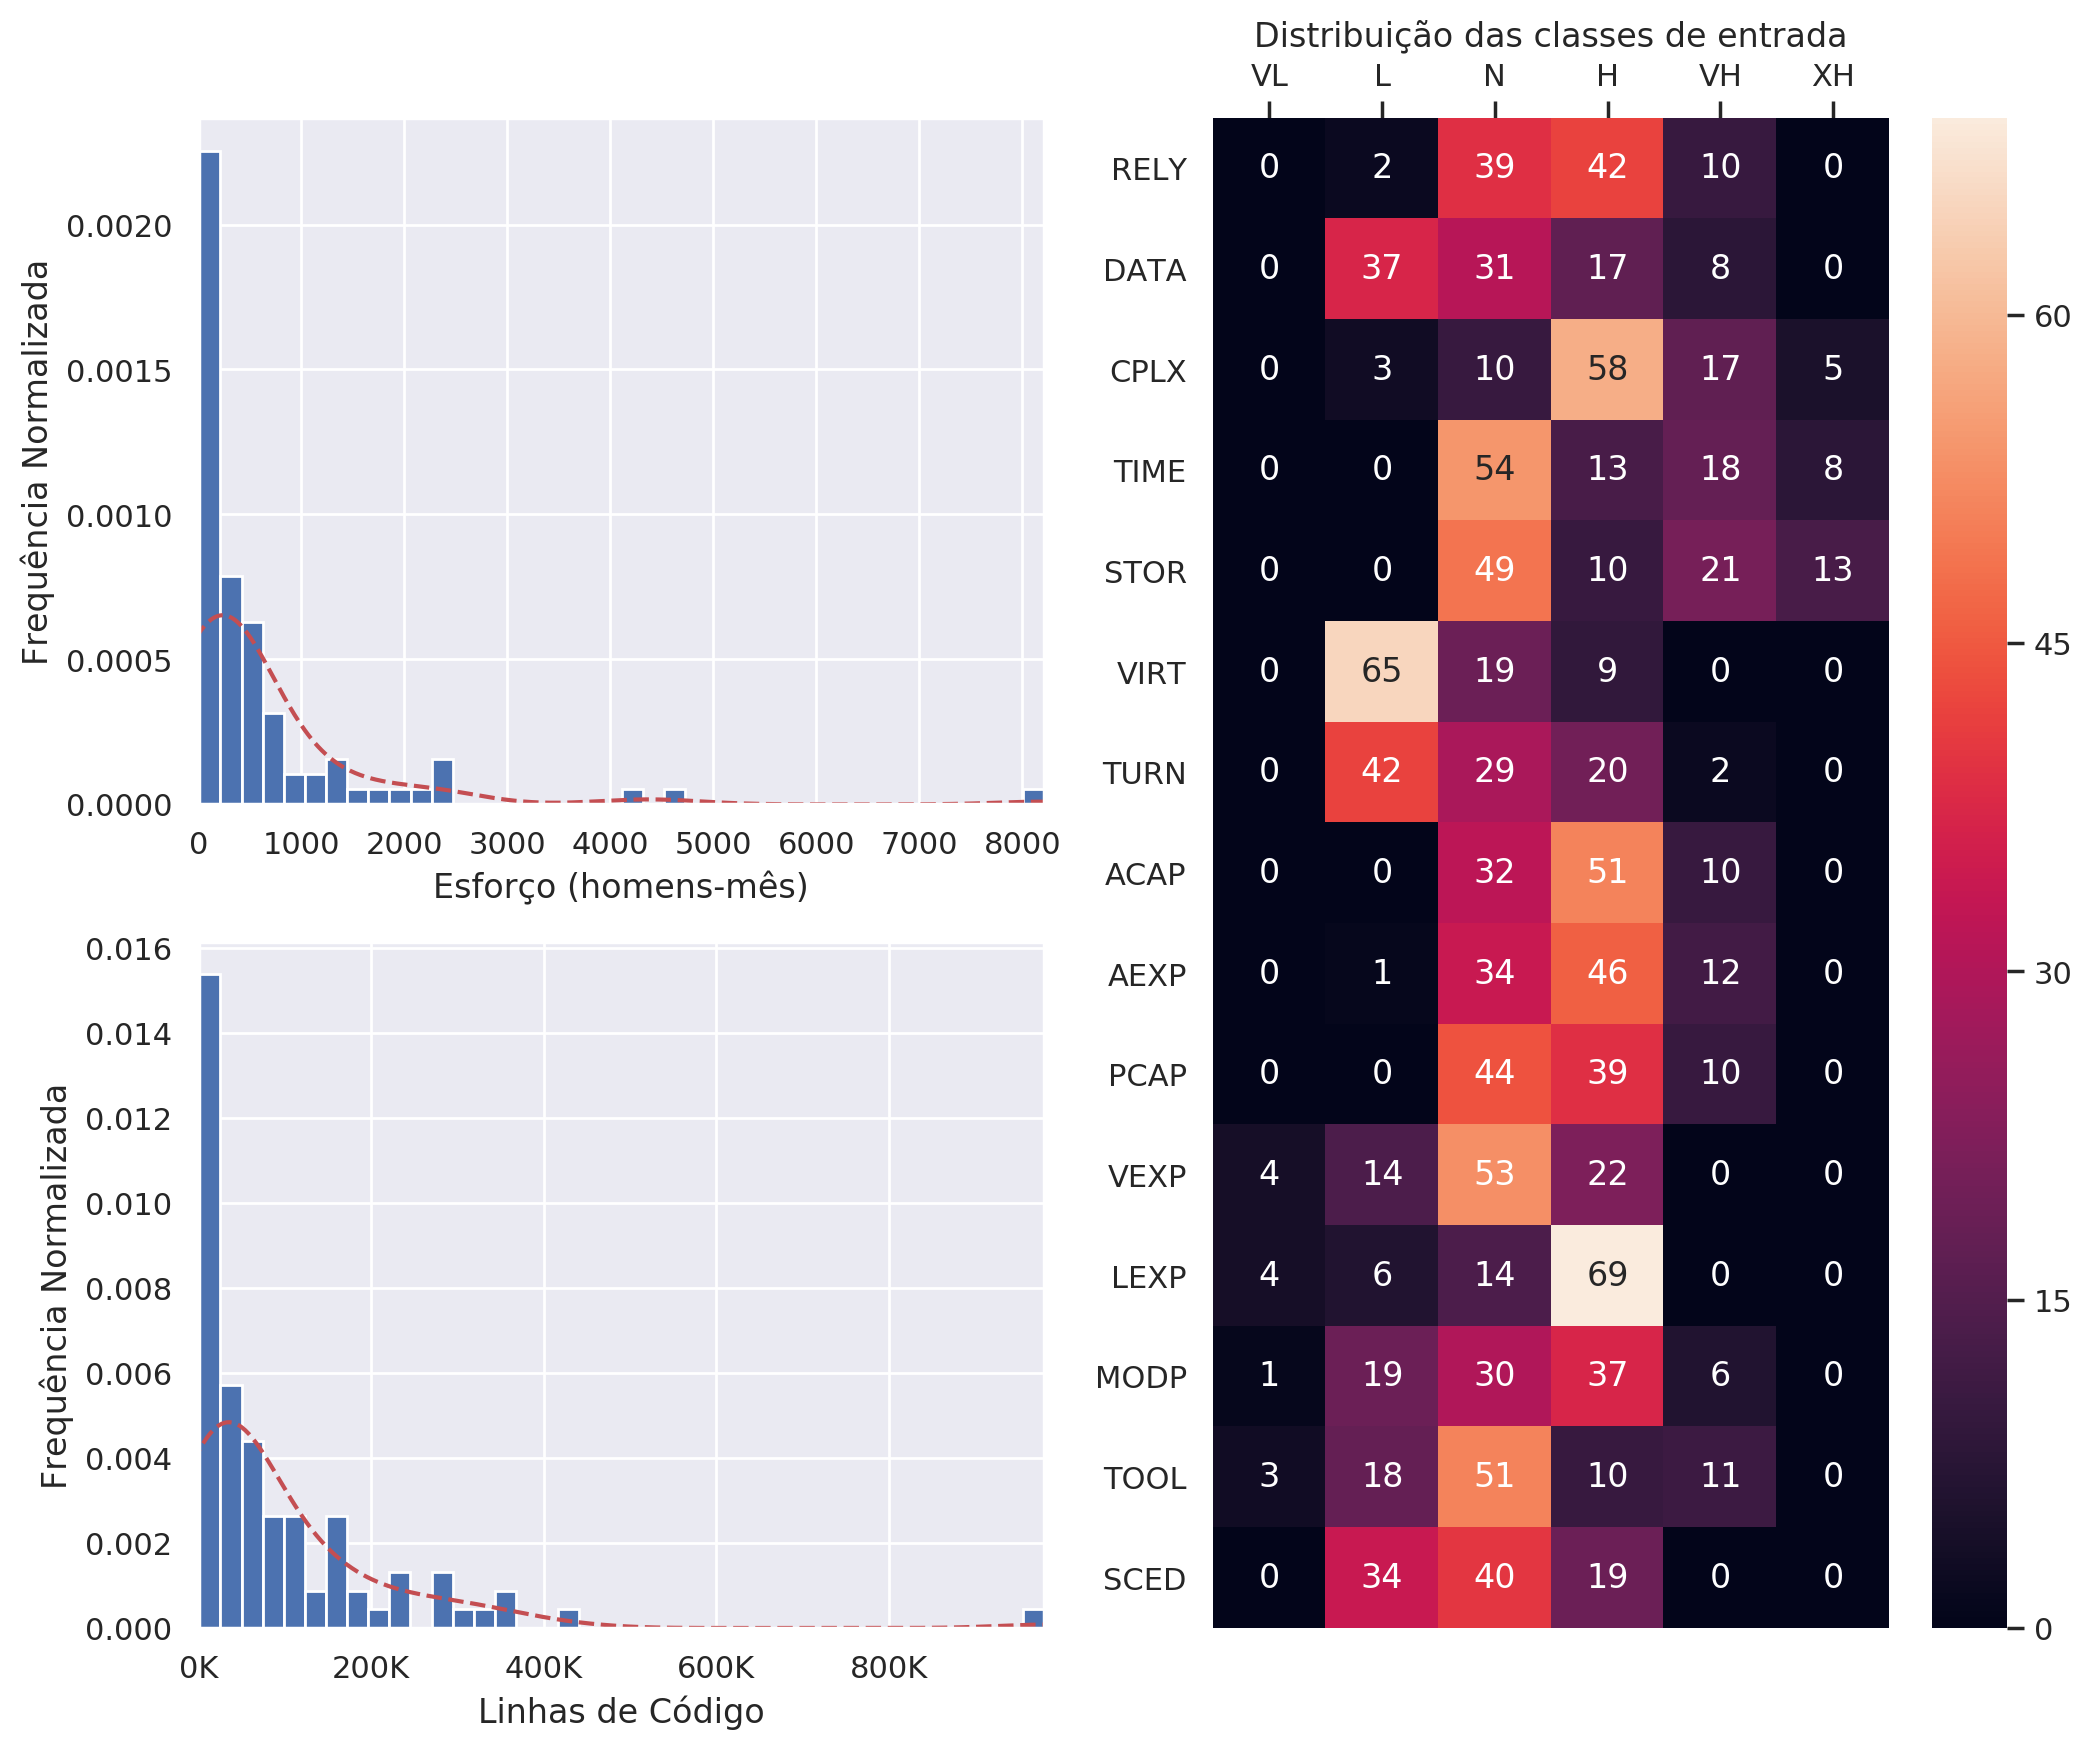

In [824]:
visualiza_dados(dados, 'cocomo_nasa2', parametros_vazios)

## Criação do modelo COCOMO neural

### Tratamento dos parâmetros do COCOMO 2000

In [5]:
params = pd.read_csv('dados/params-cocomo2000.csv', index_col=0)
params

Symbol    VL     L     N     H    VH    XH
Driver                                           
PREC      SF1  6.20  4.96  3.72  2.48  1.24  0.00
FLEX      SF2  5.07  4.05  3.04  2.03  1.01  0.00
RESL      SF3  7.07  5.65  4.24  2.83  1.41  0.00
TEAM      SF4  5.48  4.38  3.29  2.19  1.10  0.00
PMAT      SF5  7.80  6.24  4.68  3.12  1.56  0.00
RELY      EM1  0.82  0.92  1.00  1.10  1.26   NaN
DATA      EM2   NaN  0.90  1.00  1.14  1.28   NaN
CPLX      EM3  0.73  0.87  1.00  1.17  1.34  1.74
RUSE      EM4   NaN  0.95  1.00  1.07  1.15  1.24
DOCU      EM5  0.81  0.91  1.00  1.11  1.23   NaN
TIME      EM6   NaN   NaN  1.00  1.11  1.29  1.63
STOR      EM7   NaN   NaN  1.00  1.05  1.17  1.46
PVOL      EM8   NaN  0.87  1.00  1.15  1.30   NaN
ACAP      EM9  1.42  1.19  1.00  0.85  0.71   NaN
PCAP     EM10  1.34  1.15  1.00  0.88  0.76   NaN
PCON     EM11  1.29  1.12  1.00  0.90  0.81   NaN
APEX     EM12  1.22  1.10  1.00  0.88  0.81   NaN
PLEX     EM13  1.19  1.09  1.00  0.91  0.85   NaN
LTEX     EM14  1.20  1.09  1.00  0.91  0.84   NaN
TOOL     EM15  1.17  1.09  1.00  0.90  0.78   NaN
SITE     EM16  1.22  1.09  1.00  0.93  0.86  0.80
SCED     EM17  1.43  1.14  1.00  1.00  1.00   NaN

In [162]:
pd.read_csv('dados/params-cocomo2000-early.csv', index_col=0)

Symbol    XL    VL     L    N     H    VH    XH
Driver                                                
PERS      EM1  2.12  1.62  1.26  1.0  0.83  0.63  0.50
RCPX      EM2  0.49  0.60  0.83  1.0  1.33  1.91  2.72
PDIF      EM3   NaN   NaN  0.87  1.0  1.29  1.81  2.61
PREX      EM4  1.59  1.33  1.12  1.0  0.87  0.74  0.62
FCIL      EM5  1.43  1.30  1.10  1.0  0.87  0.73  0.62
RUSE      EM6   NaN   NaN  0.95  1.0  1.07  1.15  1.24
SCED      EM7   NaN  1.43  1.14  1.0  1.00  1.00   NaN

In [6]:
params_constantes = pd.read_csv('dados/params-cocomo2000-constants.csv', index_col=0)
params_constantes

Baseline  Value
Constants                 
A            Effort   2.94
B            Effort   0.91
C          Schedule   3.67
D          Schedule   0.28

In [7]:
def matrix_interpolada(tabela_cocomo):
    valores_params = tabela_cocomo[tabela_cocomo.columns[1:]].values
    for i in range(valores_params.shape[0]):
        a = valores_params[i]
        nans = np.isnan(a)
        if nans.sum() > 0:
            s = np.linalg.lstsq(np.vstack([np.nonzero(~nans)[0], np.ones(len(a[~nans]))]).T, a[~nans], rcond=None)[0]
            valores_params[i, nans] = np.nonzero(nans)[0]*s[0] + s[1]
    return valores_params

valores_params = matrix_interpolada(params)
valores_params

array([[6.2  , 4.96 , 3.72 , 2.48 , 1.24 , 0.   ],
       [5.07 , 4.05 , 3.04 , 2.03 , 1.01 , 0.   ],
       [7.07 , 5.65 , 4.24 , 2.83 , 1.41 , 0.   ],
       [5.48 , 4.38 , 3.29 , 2.19 , 1.1  , 0.   ],
       [7.8  , 6.24 , 4.68 , 3.12 , 1.56 , 0.   ],
       [0.82 , 0.92 , 1.   , 1.1  , 1.26 , 1.338],
       [0.76 , 0.9  , 1.   , 1.14 , 1.28 , 1.4  ],
       [0.73 , 0.87 , 1.   , 1.17 , 1.34 , 1.74 ],
       [0.863, 0.95 , 1.   , 1.07 , 1.15 , 1.24 ],
       [0.81 , 0.91 , 1.   , 1.11 , 1.23 , 1.324],
       [0.533, 0.74 , 1.   , 1.11 , 1.29 , 1.63 ],
       [0.645, 0.795, 1.   , 1.05 , 1.17 , 1.46 ],
       [0.72 , 0.87 , 1.   , 1.15 , 1.3  , 1.44 ],
       [1.42 , 1.19 , 1.   , 0.85 , 0.71 , 0.506],
       [1.34 , 1.15 , 1.   , 0.88 , 0.76 , 0.597],
       [1.29 , 1.12 , 1.   , 0.9  , 0.81 , 0.67 ],
       [1.22 , 1.1  , 1.   , 0.88 , 0.81 , 0.69 ],
       [1.19 , 1.09 , 1.   , 0.91 , 0.85 , 0.75 ],
       [1.2  , 1.09 , 1.   , 0.91 , 0.84 , 0.738],
       [1.17 , 1.09 , 1.   , 0.

In [8]:
def imprime_linha(vetor):
    for i in vetor[:-1]:
        print(i, end=' & ')
    print(vetor[-1], end=' \\\\ \n')
print('\\begin{tabular}{rrrrrrrrrrrrrrrrrr}\n\\toprule')
imprime_linha(params.columns.values)
print('\\midrule')
for i, nome in enumerate(params.index.values):
    print(nome, end=' & ')
    imprime_linha(valores_params[i,:].round(2))
print('\\bottomrule\n\\end{tabular}')

\begin{tabular}{rrrrrrrrrrrrrrrrrr}
\toprule
Symbol & VL & L & N & H & VH & XH \\ 
\midrule
PREC & 6.2 & 4.96 & 3.72 & 2.48 & 1.24 & 0.0 \\ 
FLEX & 5.07 & 4.05 & 3.04 & 2.03 & 1.01 & 0.0 \\ 
RESL & 7.07 & 5.65 & 4.24 & 2.83 & 1.41 & 0.0 \\ 
TEAM & 5.48 & 4.38 & 3.29 & 2.19 & 1.1 & 0.0 \\ 
PMAT & 7.8 & 6.24 & 4.68 & 3.12 & 1.56 & 0.0 \\ 
RELY & 0.82 & 0.92 & 1.0 & 1.1 & 1.26 & 1.34 \\ 
DATA & 0.76 & 0.9 & 1.0 & 1.14 & 1.28 & 1.4 \\ 
CPLX & 0.73 & 0.87 & 1.0 & 1.17 & 1.34 & 1.74 \\ 
RUSE & 0.86 & 0.95 & 1.0 & 1.07 & 1.15 & 1.24 \\ 
DOCU & 0.81 & 0.91 & 1.0 & 1.11 & 1.23 & 1.32 \\ 
TIME & 0.53 & 0.74 & 1.0 & 1.11 & 1.29 & 1.63 \\ 
STOR & 0.64 & 0.79 & 1.0 & 1.05 & 1.17 & 1.46 \\ 
PVOL & 0.72 & 0.87 & 1.0 & 1.15 & 1.3 & 1.44 \\ 
ACAP & 1.42 & 1.19 & 1.0 & 0.85 & 0.71 & 0.51 \\ 
PCAP & 1.34 & 1.15 & 1.0 & 0.88 & 0.76 & 0.6 \\ 
PCON & 1.29 & 1.12 & 1.0 & 0.9 & 0.81 & 0.67 \\ 
APEX & 1.22 & 1.1 & 1.0 & 0.88 & 0.81 & 0.69 \\ 
PLEX & 1.19 & 1.09 & 1.0 & 0.91 & 0.85 & 0.75 \\ 
LTEX & 1.2 & 1.09 

In [9]:
def gerar_pesos_rede(matriz_cocomo, quant_SF, dim_entrada, dim_inicial, dim_intermediaria, A, B):
    pesos_iniciais = np.zeros((dim_entrada, dim_inicial), dtype=np.float32)
    pesos_iniciais[0, 0] = 1
    pesos_iniciais[1:quant_SF*matriz_cocomo.shape[1]+1, 1] = 0.01 * np.ravel(matriz_cocomo[:quant_SF,:])
    pesos_iniciais[quant_SF*matriz_cocomo.shape[1]+1:, 2] = np.log(np.ravel(matriz_cocomo[quant_SF:,:]))
    polarizacao_inicial = np.array([0, B, np.log(A)], dtype=np.float32)
    pesos_log = np.zeros((dim_inicial, dim_intermediaria), dtype=np.float32)
    pesos_log[0, 0] = 1
    polarizacao_log = np.zeros(dim_intermediaria, dtype=np.float32)
    polarizacao_log[1] = np.e
    pesos_recombina = np.zeros((dim_inicial, dim_intermediaria), dtype=np.float32)
    pesos_recombina[1:, :] = np.eye(dim_intermediaria)
    polarizacao_recombina = np.zeros(dim_intermediaria, dtype=np.float32)
    peso_exponencial = np.ones((1, 1))
    polarizacao_exponencial = np.zeros(1)
    pesos_rede = [pesos_iniciais, polarizacao_inicial, pesos_log, polarizacao_log, pesos_recombina, polarizacao_recombina, peso_exponencial, polarizacao_exponencial]
    return pesos_rede

quant_SF = params['Symbol'].str.contains('SF').sum()
dim_entrada = valores_params.size + 1
pesos_rede = gerar_pesos_rede(valores_params, quant_SF, dim_entrada, dim_inicial, dim_intermediaria, params_constantes.loc['A', 'Value'], params_constantes.loc['B', 'Value'])
pesos_rede

[array([[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.062     ,  0.        ],
        [ 0.        ,  0.0496    ,  0.        ],
        [ 0.        ,  0.0372    ,  0.        ],
        [ 0.        ,  0.0248    ,  0.        ],
        [ 0.        ,  0.0124    ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.0507    ,  0.        ],
        [ 0.        ,  0.0405    ,  0.        ],
        [ 0.        ,  0.0304    ,  0.        ],
        [ 0.        ,  0.0203    ,  0.        ],
        [ 0.        ,  0.0101    ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.0707    ,  0.        ],
        [ 0.        ,  0.0565    ,  0.        ],
        [ 0.        ,  0.0424    ,  0.        ],
        [ 0.        ,  0.0283    ,  0.        ],
        [ 0.        ,  0.0141    ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.0548    ,  0.        ],
        [ 0.        

### Instanciação e inicialização dos redes com os pesos

In [90]:
keras.backend.constant?

In [93]:
class AtivacaoLog(keras.layers.Layer):

    def __init__(self, dim_saida, inicializador='uniform', **kwargs):
        self.dim_saida = dim_saida
        self.inicializador = inicializador
        super(AtivacaoLog, self).__init__(**kwargs)

    def build(self, dim_entrada):
        self.pesos = self.add_weight(name='pesos',shape=(dim_entrada[1], self.dim_saida),initializer=self.inicializador,trainable=True)
        self.polarizacao = self.add_weight(name='polarizacao', shape=(self.dim_saida,), initializer='zeros')
        super(AtivacaoLog, self).build(dim_entrada)

    def call(self, dados):
        return keras.backend.log(keras.backend.bias_add(keras.backend.relu(keras.backend.bias_add(keras.backend.dot(dados, self.pesos), self.polarizacao, data_format='channels_last')), keras.backend.constant(10**-30, shape=(self.dim_saida,)), data_format='channels_last'))

    def compute_output_shape(self, dim_entrada):
        return (dim_entrada[0], self.dim_saida)

In [94]:
def constroi_modelo(dim_entrada, dim_inicial, dim_intermediaria):
    entrada = keras.layers.Input(shape=(dim_entrada,), dtype='float32', name='entrada')
    combina_linear = keras.layers.Dense(dim_inicial, name='combina_linear')(entrada)
    combina_log = AtivacaoLog(dim_intermediaria, name='combina_log')(combina_linear)
    recombina_relu = keras.layers.Dense(dim_intermediaria, name='combina_relu')(combina_linear)
    produto_interno = keras.layers.dot([combina_log, recombina_relu], axes=1, name='produto_interno')
    saida = keras.layers.Dense(1, activation='exponential', name='saida')(produto_interno)
    return keras.models.Model(inputs=entrada, outputs=saida)

modelo_cocomo = constroi_modelo(dim_entrada, dim_inicial, dim_intermediaria)
modelo_cocomo.compile(loss='mse',optimizer='adam')
modelo_cocomo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entrada (InputLayer)            (None, 133)          0                                            
__________________________________________________________________________________________________
combina_linear (Dense)          (None, 3)            402         entrada[0][0]                    
__________________________________________________________________________________________________
combina_log (AtivacaoLog)       (None, 2)            8           combina_linear[0][0]             
__________________________________________________________________________________________________
combina_relu (Dense)            (None, 2)            8           combina_linear[0][0]             
__________________________________________________________________________________________________
produto_in

In [95]:
modelo_cocomo.set_weights(pesos_rede)
modelo_cocomo.get_weights()

[array([[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.062     ,  0.        ],
        [ 0.        ,  0.0496    ,  0.        ],
        [ 0.        ,  0.0372    ,  0.        ],
        [ 0.        ,  0.0248    ,  0.        ],
        [ 0.        ,  0.0124    ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.0507    ,  0.        ],
        [ 0.        ,  0.0405    ,  0.        ],
        [ 0.        ,  0.0304    ,  0.        ],
        [ 0.        ,  0.0203    ,  0.        ],
        [ 0.        ,  0.0101    ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.0707    ,  0.        ],
        [ 0.        ,  0.0565    ,  0.        ],
        [ 0.        ,  0.0424    ,  0.        ],
        [ 0.        ,  0.0283    ,  0.        ],
        [ 0.        ,  0.0141    ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.0548    ,  0.        ],
        [ 0.        

## Comparação entre os modelos

Exemplificação da equivalência matemática entre os modelos

### Formatação dos dados

In [13]:
def formata_dados_tabela(tabela, dim_entrada, params):
    classes = [a.lower() for a in params.columns[1:]]
    em_texto = tabela.loc[:, params.index].values
    um_ativo = np.zeros((em_texto.shape[0], dim_entrada), dtype=np.float32)
    for i, k in enumerate(classes):
        lugares = [1 + i + len(classes) * j for j in range(em_texto.shape[1])]
        um_ativo[:, lugares] = (em_texto == k)
    um_ativo[:,0] = tabela.loc[:, 'KLOC'].values
    return um_ativo

def estimativa_cocomo2000(KSLOC, fatores_escala, multiplicadores, A, B):
    return A * (KSLOC ** (B + 0.01*np.sum(fatores_escala))) * np.prod(multiplicadores)

def estimativa_cocomo2000_tabela(tabela, params, A, B):
    SFs = params.index[params['Symbol'].str.contains('SF')].values
    EMs = params.index[params['Symbol'].str.contains('EM')].values
    return np.array([estimativa_cocomo2000(
        dado['KLOC'],
        [params.loc[sf, dado[sf].upper()] for sf in SFs],
        [params.loc[em, dado[em].upper()] for em in EMs], A, B
    ) for i, dado in tabela.iterrows()]).reshape((tabela.shape[0], 1))

### Gráficos e análises estatísticas

Base de dados: cocomo81
Diferença Relativa Máxima: 7.653129834291528e-07
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.877e+15
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:14:56   Log-Likelihood:                 467.89
No. Observations:                  63   AIC:                            -931.8
Df Residuals:                      61   BIC:                            -927.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Base de dados: cocomo_nasa2000
Diferença Relativa Máxima: 1.1090244259427261e-06
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.294e+14
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:14:56   Log-Likelihood:                 663.49
No. Observations:                 106   AIC:                            -1323.
Df Residuals:                     104   BIC:                            -1318.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


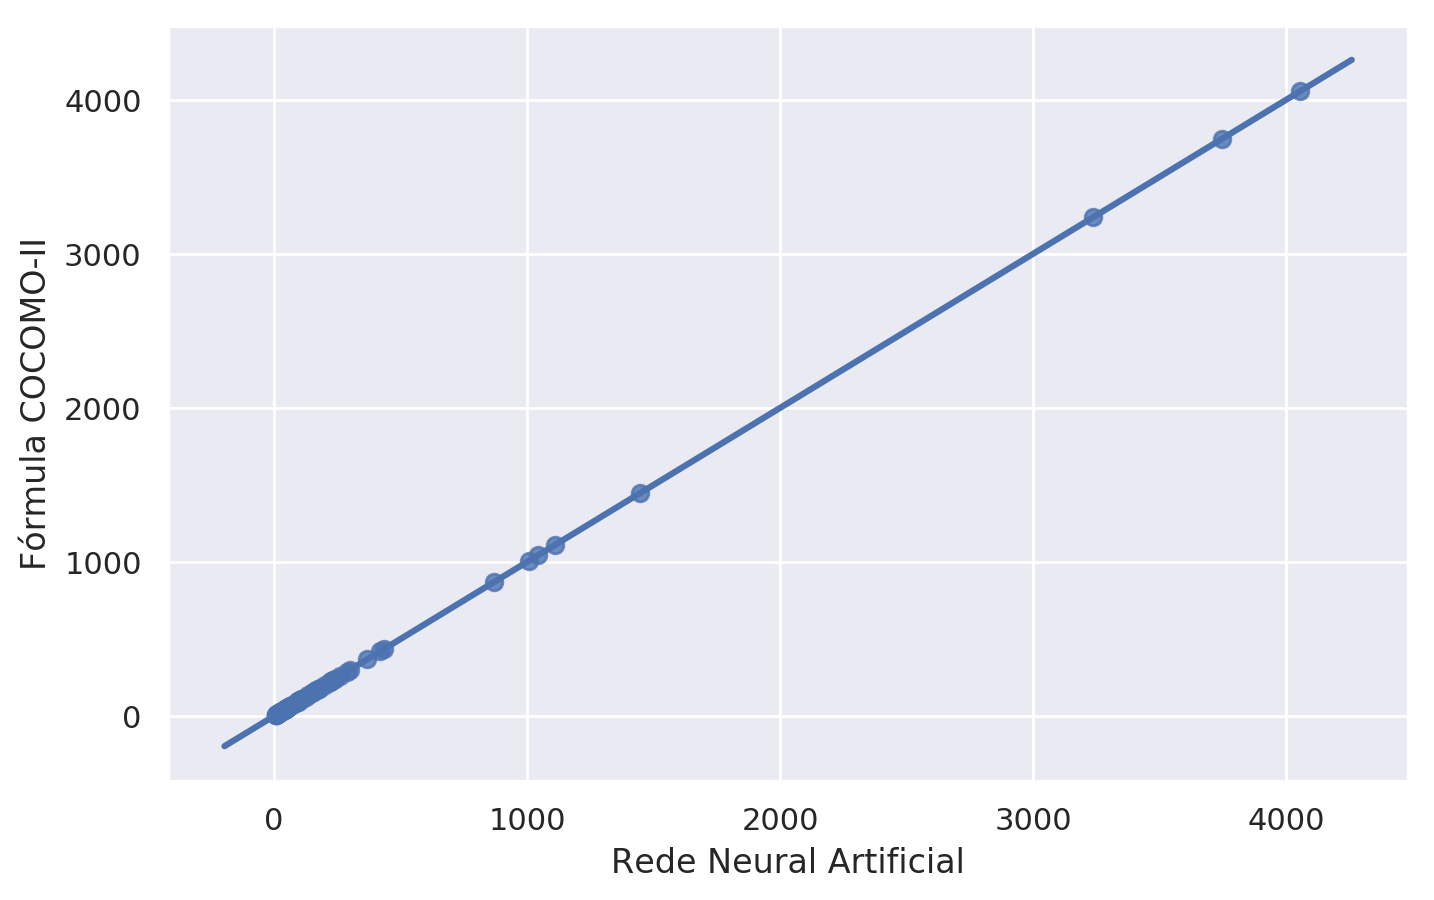

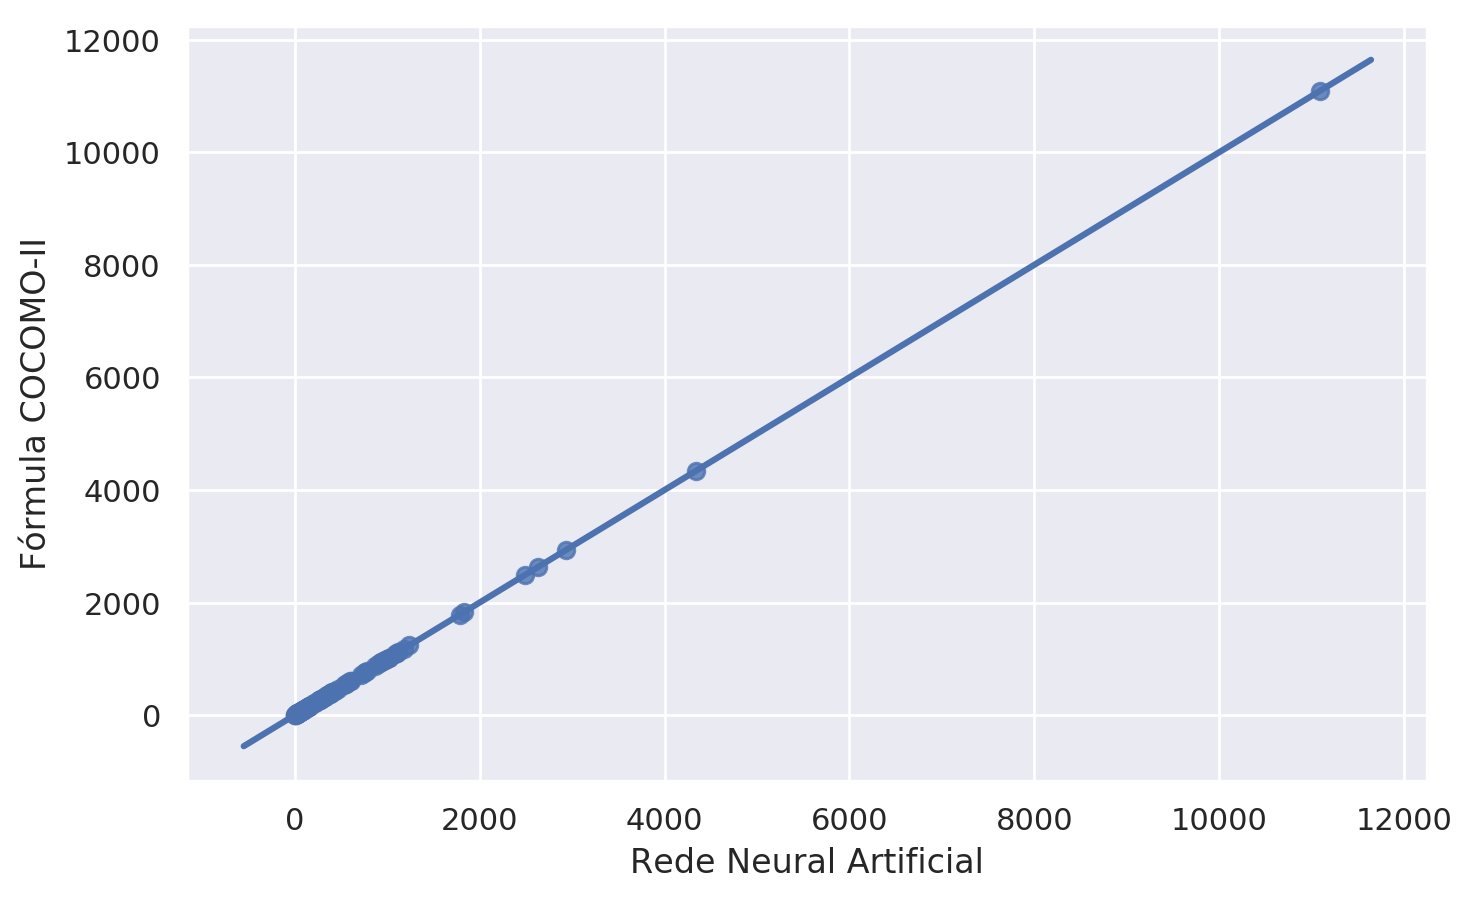

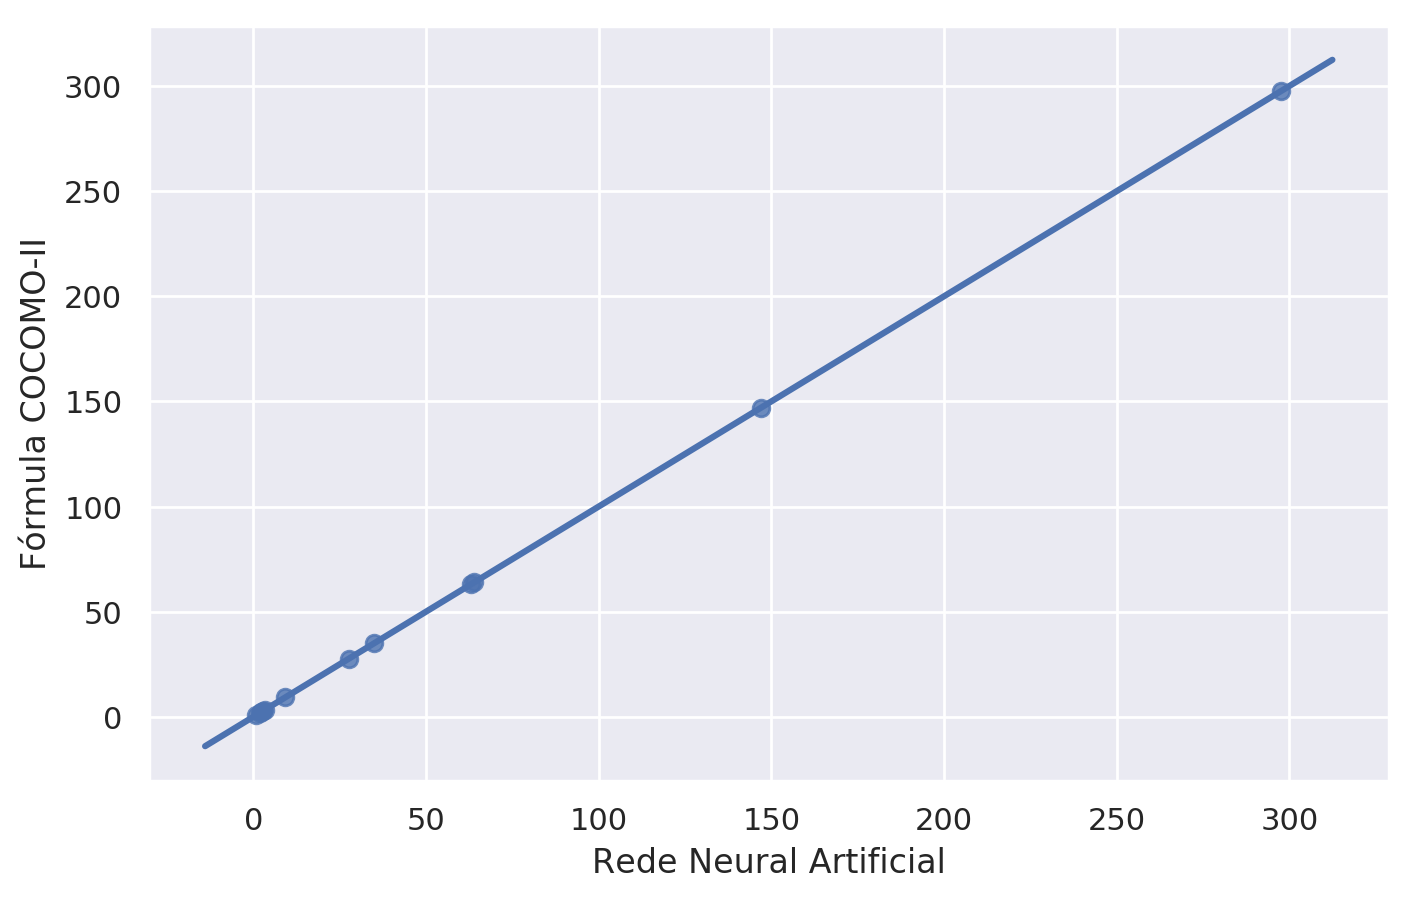

In [752]:
for base in ['cocomo81', 'cocomo_nasa2000', 'cocomo_sdr']:
    print('Base de dados:', base)
    entrada_one_hot = formata_dados_tabela(dados[base], dim_entrada, params)
    saida_rede = modelo_cocomo.predict(entrada_one_hot)
    saida_parametrica = estimativa_cocomo2000_tabela(dados[base], params, params_constantes.loc['A', 'Value'], params_constantes.loc['B', 'Value'])
    print('Diferença Relativa Máxima:', np.max(np.abs(((saida_rede - saida_parametrica)/saida_parametrica))))
    results = sm.OLS(saida_rede.ravel(),sm.add_constant(saida_parametrica.ravel())).fit()
    print(results.summary())
    figura = plt.figure(figsize=(8, 5), dpi=200)
    plt.xlabel("Rede Neural Artificial")
    plt.ylabel("Fórmula COCOMO-II")
    sns.regplot(saida_rede.ravel(), saida_parametrica.ravel())
    plt.plot()
    figura.savefig("resultados/figuras/"+base+"-rna-vs.pdf", bbox_inches='tight')

## Comparação com o esforço real

Base de dados: cocomo81
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     495.3
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           5.66e-31
Time:                        09:15:08   Log-Likelihood:                -492.23
No. Observations:                  63   AIC:                             988.5
Df Residuals:                      61   BIC:                             992.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -91.0116     84

/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


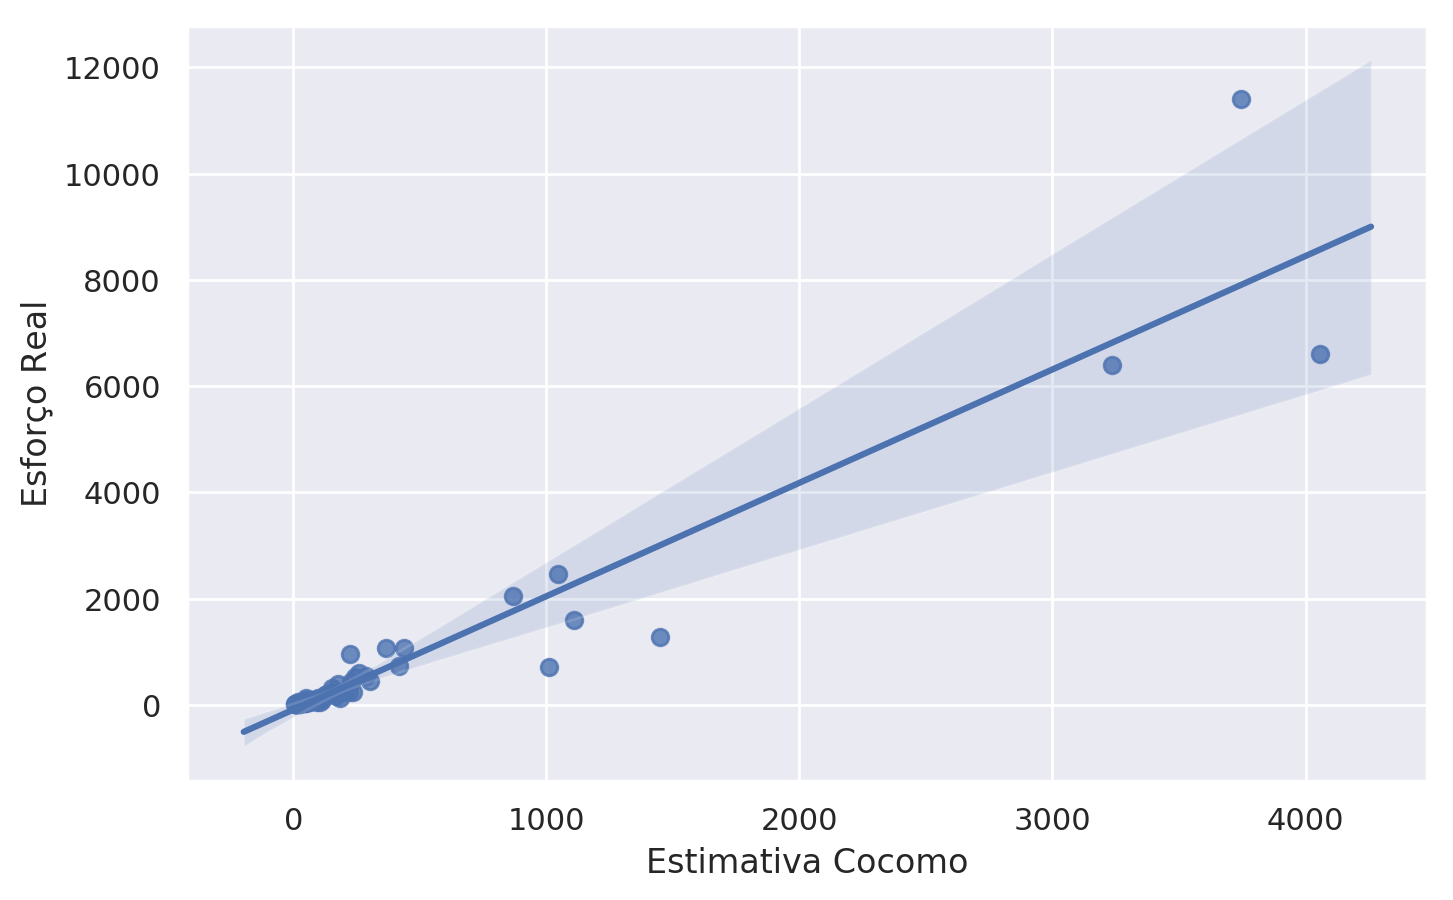

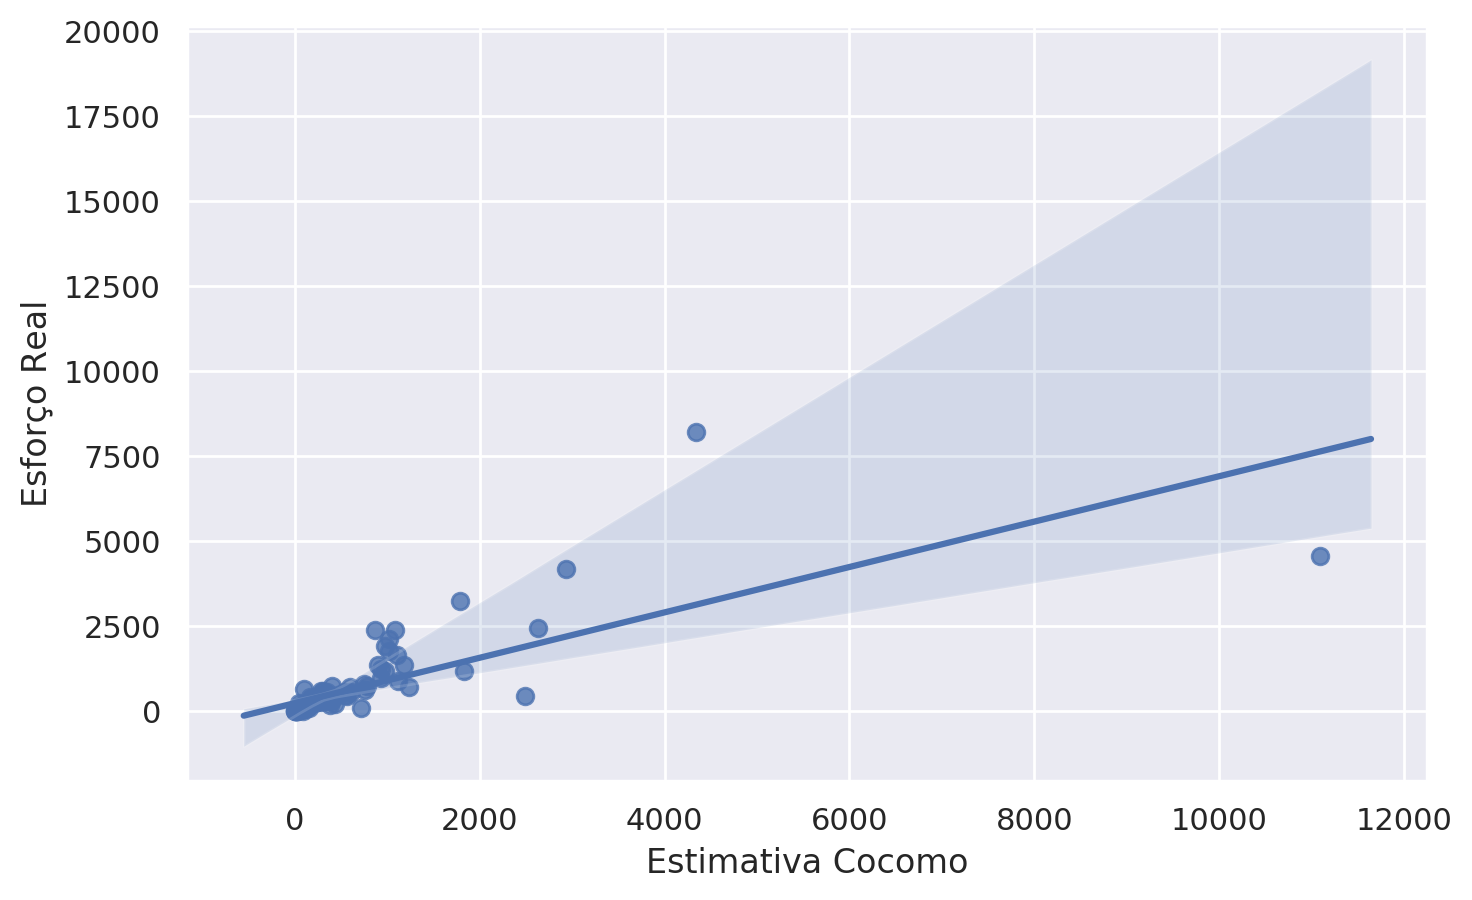

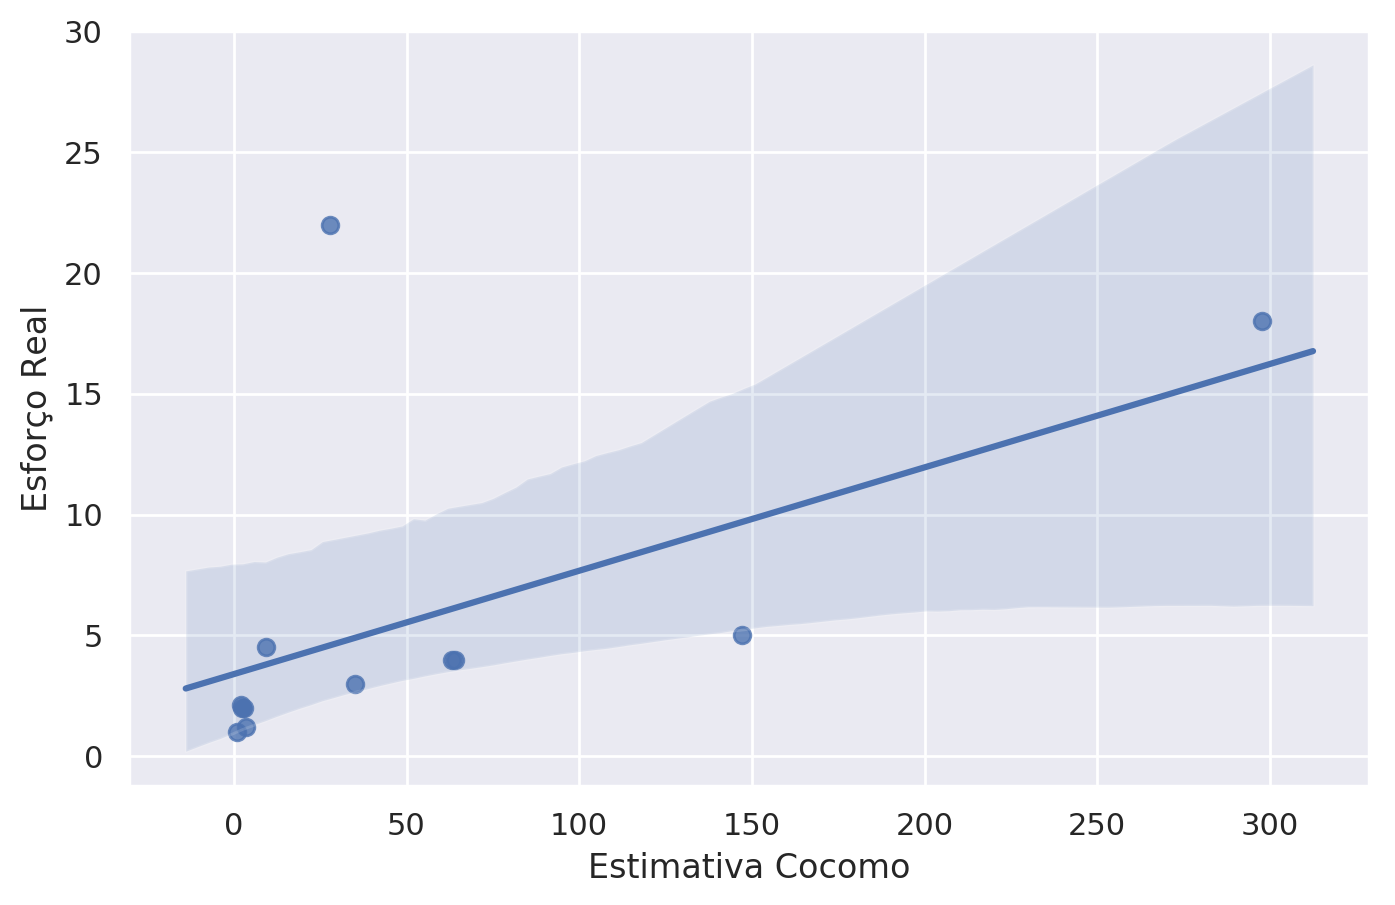

In [753]:
for base in ['cocomo81', 'cocomo_nasa2000', 'cocomo_sdr']:
    print('Base de dados:', base)
    saida_real = dados[base]['Effort'].values
    saida_parametrica = estimativa_cocomo2000_tabela(dados[base], params, params_constantes.loc['A', 'Value'], params_constantes.loc['B', 'Value'])
    results = sm.OLS(saida_real,sm.add_constant(saida_parametrica.ravel())).fit()
    print(results.summary())
    figura = plt.figure(figsize=(8, 5), dpi=200)
    plt.xlabel("Estimativa Cocomo")
    plt.ylabel("Esforço Real")
    sns.regplot(saida_parametrica.ravel(), saida_real)
    plt.plot()
    figura.savefig("resultados/figuras/"+base+"-coc-real.pdf", bbox_inches='tight')

## Utilização de Pontos de Função

In [14]:
dados_afp = carregar_tudo(caminho_dados_afp)
dados_afp.keys()

dict_keys(['desharnais', 'china', 'kitchenham', 'kemerer', 'albrecht'])

In [981]:
dados_afp['kitchenham']

ID  Client code Project type  Start date  Duration  Effort      AFP  \
0      1            1            A  1996-12-10       107     485   101.65   
1      2            1            D  1997-06-16       144     990    57.12   
2      3            1            D  1997-03-01       604   13635  1010.88   
3      4            1            P  1997-06-23       226    1576    45.60   
4      5            1            D  1997-01-20       326    3826  1022.58   
5      6            1            P  1997-12-10       294    1079    77.04   
6      7            1            A  1998-07-06       212    2224   159.60   
7      8            1            C  1997-12-08       175    1698   225.54   
8      9            1           Pr  1997-05-05       584    1173   144.72   
9     10            1            D  1997-03-18       171    1401    84.42   
10    11            1            D  1997-06-01       201    2170   126.42   
11    12            1            D  1997-08-14       195    1122   392.16   
12    13            1            U  1997-07-21       109    1024    18.90   
13    14            1            P  1997-06-23       263    1832   112.14   
14    15            1            A  1997-07-10       165    1016   210.08   
15    16            1            D  1997-03-15        46     322   260.95   
16    17            2            D  1995-12-18       186     580   609.70   
17    18            2            D  1995-06-26       189    1003   169.85   
18    19            2            P  1995-06-26        95     380    56.00   
19    20            2            P  1995-09-25        53     220    30.00   
20    21            2            P  1997-10-07       365    2356   241.86   
21    22            2            P  1994-12-19       438    1388   219.88   
22    23            2            P  1996-03-11       109    1066   229.71   
23    24            2            D  1996-08-05       283    2860   458.38   
24    25            2            P  1998-01-12       137    1143   177.63   
25    26            2            P  1997-05-12       102    1431   287.64   
26    27            2            P  1997-06-09       103    1868   343.54   
27    28            2            P  1997-07-01       192    2172   346.80   
28    29            2            D  1996-08-14       219    8509  1121.48   
29    30            2            P  1995-02-17       484    5927   761.08   
..   ...          ...          ...         ...       ...     ...      ...   
115  116            2            D  1994-12-12       186    2895   857.00   
116  117            2            D  1994-12-09        63     322    69.00   
117  118            2            A  1995-10-09       192    3555   980.95   
118  119            2            P  1995-02-13       123     570   100.80   
119  120            2            P  1997-05-02       123     464   105.28   
120  121            2            D  1997-01-13       186    1742   158.40   
121  122            2            D  1998-09-18       119     896   219.88   
122  123            2            P  1997-11-01       195    8656  1292.56   
123  124            2            P  1997-11-07       210    3966   616.08   
124  125            2            D  1994-09-04       180     989   103.40   
125  126            2            P  1998-05-30       238     585    74.40   
126  127            2            P  1997-09-16       144    1860   356.31   
127  128            2            P  1997-12-08       432    5249   862.00   
128  129            2            P  1997-06-27       392    5192   791.84   
129  130            2            D  1998-08-01       205    1832   661.27   
130  131            2            D  1995-01-13        49     928   179.00   
131  132            3            P  1996-06-10       205    2570   518.40   
132  133            3            D  1995-01-01       145    1328   370.00   
133  134            3            D  1997-02-02       172    2964   839.05   
134  135            3            P  1997-07-21       137    1304   243.86   
13

In [917]:
print(dados['cocomo_sdr'].transpose().to_latex(index=True).replace('.', ','))

\begin{tabular}{lllllllllllll}
\toprule
{} &   0  &  1  &    2  &  3  &  4  &     5  &    6  &      7  &      8  &      9  &     10 &     11 \\
\midrule
ID     &    1 &   2 &     3 &   4 &   5 &      6 &     7 &       8 &       9 &      10 &     11 &     12 \\
PREC   &   vh &  vh &    xh &  xh &   n &     vh &    xh &       n &      vl &       n &      h &      l \\
FLEX   &    n &   n &     n &   h &   n &      l &    vh &      vl &      vl &      vl &      n &      n \\
RESL   &    l &   l &     l &   h &   l &     xh &    xh &      vh &       n &      vh &     vh &      n \\
TEAM   &    h &  vh &     h &   h &   h &     xh &     n &       n &      vl &       l &      h &      h \\
PMAT   &   vl &  vl &    vl &   n &   n &      h &     h &       l &       l &       l &      l &      n \\
RELY   &    n &   h &     h &   h &   l &      l &     l &       l &      vl &      vl &      l &      l \\
DATA   &    n &   n &    vh &   h &   n &      l &     l &      vh &       n &       h &   

In [714]:
pd.read_csv('dados/pontos-funcao/albrecht.csv', skipinitialspace=True)[['Effort'] + afp_headers]

Effort  Input  Output  Inquiry  File   AFP
0    102.4     25     150       75    60  1750
1    105.2    193      98       70    36  1902
2     11.1     70      27        0    12   428
3     21.1     40      60       20    12   759
4     28.8     10      69        1     9   431
5     10.0     13      19        0    23   283
6      8.0     34      14        0     5   205
7      4.9     17      17       15     5   289
8     12.9     45      64       14    16   680
9     19.0     40      60       20    15   794
10    10.8     41      27       29     5   512
11     2.9     33      17        8     5   224
12     7.5     28      41       16    11   417
13    12.0     43      40       20    35   682
14     4.1      7      12       13     8   209
15    15.8     28      38       24     9   512
16    18.3     42      57       12     5   606
17     8.9     27      20       24     6   400
18    38.1     48      66       13    50  1235
19    61.2     69     112       21    39  1572
20     3.6     25      28        4    22   500
21    11.8     61      68        0    11   694
22     0.5     15      15        6     3   199
23     6.1     12      15        0    15   260

In [15]:
china_tabela = pd.read_csv('dados/pontos-funcao/china.csv', skipinitialspace=True)
china_tabela

ID   AFP  Input  Output  Inquiry  File  Interface  Added  Changed  \
0      1  1587    774     260      340   128          0   1502        0   
1      2   260      9       4        3   193         41     51      138   
2      3   152     25      33       28    42         35    163        0   
3      4   252    151      28        8    39          0     69      153   
4      5   292     93       0      194    20          0      0      307   
5      6    83     63       0       24     0          0      0       87   
6      7    79     24       0       23    30          0      0       77   
7      8    97      0     108        7     0          5    120        0   
8      9   116      0      23       58    14         20     81       34   
9     10    52     39       7        0     0          0      0       46   
10    11   465    209     129       24    83         15    460        0   
11    12    67     32       5       16     7          0     25       35   
12    13   199      0     115       57     0         42    214        0   
13    14   176     13      54       54    40          7    168        0   
14    15   391    208      26       81    25          0     38      302   
15    16   263     65      45      101    42         10    176       87   
16    17    42     12      15        3     7         15     52        0   
17    18   190     98      20       16    63          5    160       42   
18    19   245    105      28       18    58          0     19      190   
19    20    77     28       0       42     0          0      0       70   
20    21   355    278       0       73     0          0      0      351   
21    22  3156   2075     525       97     0          0     28       12   
22    23    46      0      28        0    25          0     28       25   
23    24    56     14      12       15     7          5     53        0   
24    25   106     65       4       12    14          0     35       53   
25    26    71     31      28        9     7          0     31       23   
26    27   306     51     105        0   105         45    306        0   
27    28   244     68      78       22    62         14    244        0   
28    29    98     21      46        3    44          0    114        0   
29    30   331    100      44       61   107          0    312        0   
..   ...   ...    ...     ...      ...   ...        ...    ...      ...   
469  470   769    265     195      235    52          0    178      557   
470  471   137     54      42       30     7          0     97       36   
471  472   579    215      81      109   112          0    517        0   
472  473   133     39       0       41    24         20    124        0   
473  474    78      7      34        6    21          0     22       46   
474  475   101     12      31        3    50          0     65       28   
475  476  1222    503     333      173   150          5   1164        0   
476  477  1093    486     277      126   147          5    788      253   
477  478   222     41      57        0    99         25    222        0   
478  479  2067   1056     658       45   303          5   1510      557   
479  480   175     65      31       22    38          0    141       15   
480  481   230    180      12       41    14          0    247        0   
481  482   104     32       5       40    28         10    115        0   
482  483   177     24      79        6    42         60    211        0   
483  484    62     33       0       12    10          0     22       33   
484  485   487    146     238       53    24         12     45      428   
485  486   177     40      12       27    38         60    177        0   
486  487   105     34      66       10    37         15    162        0   
487  488   140     43      68        3    57          0    171        0   
488  489   230     81      49       37    58          0    225        0   
489  490   236    102      84       52     0          0    238        0   
490  491   846    322      56  

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


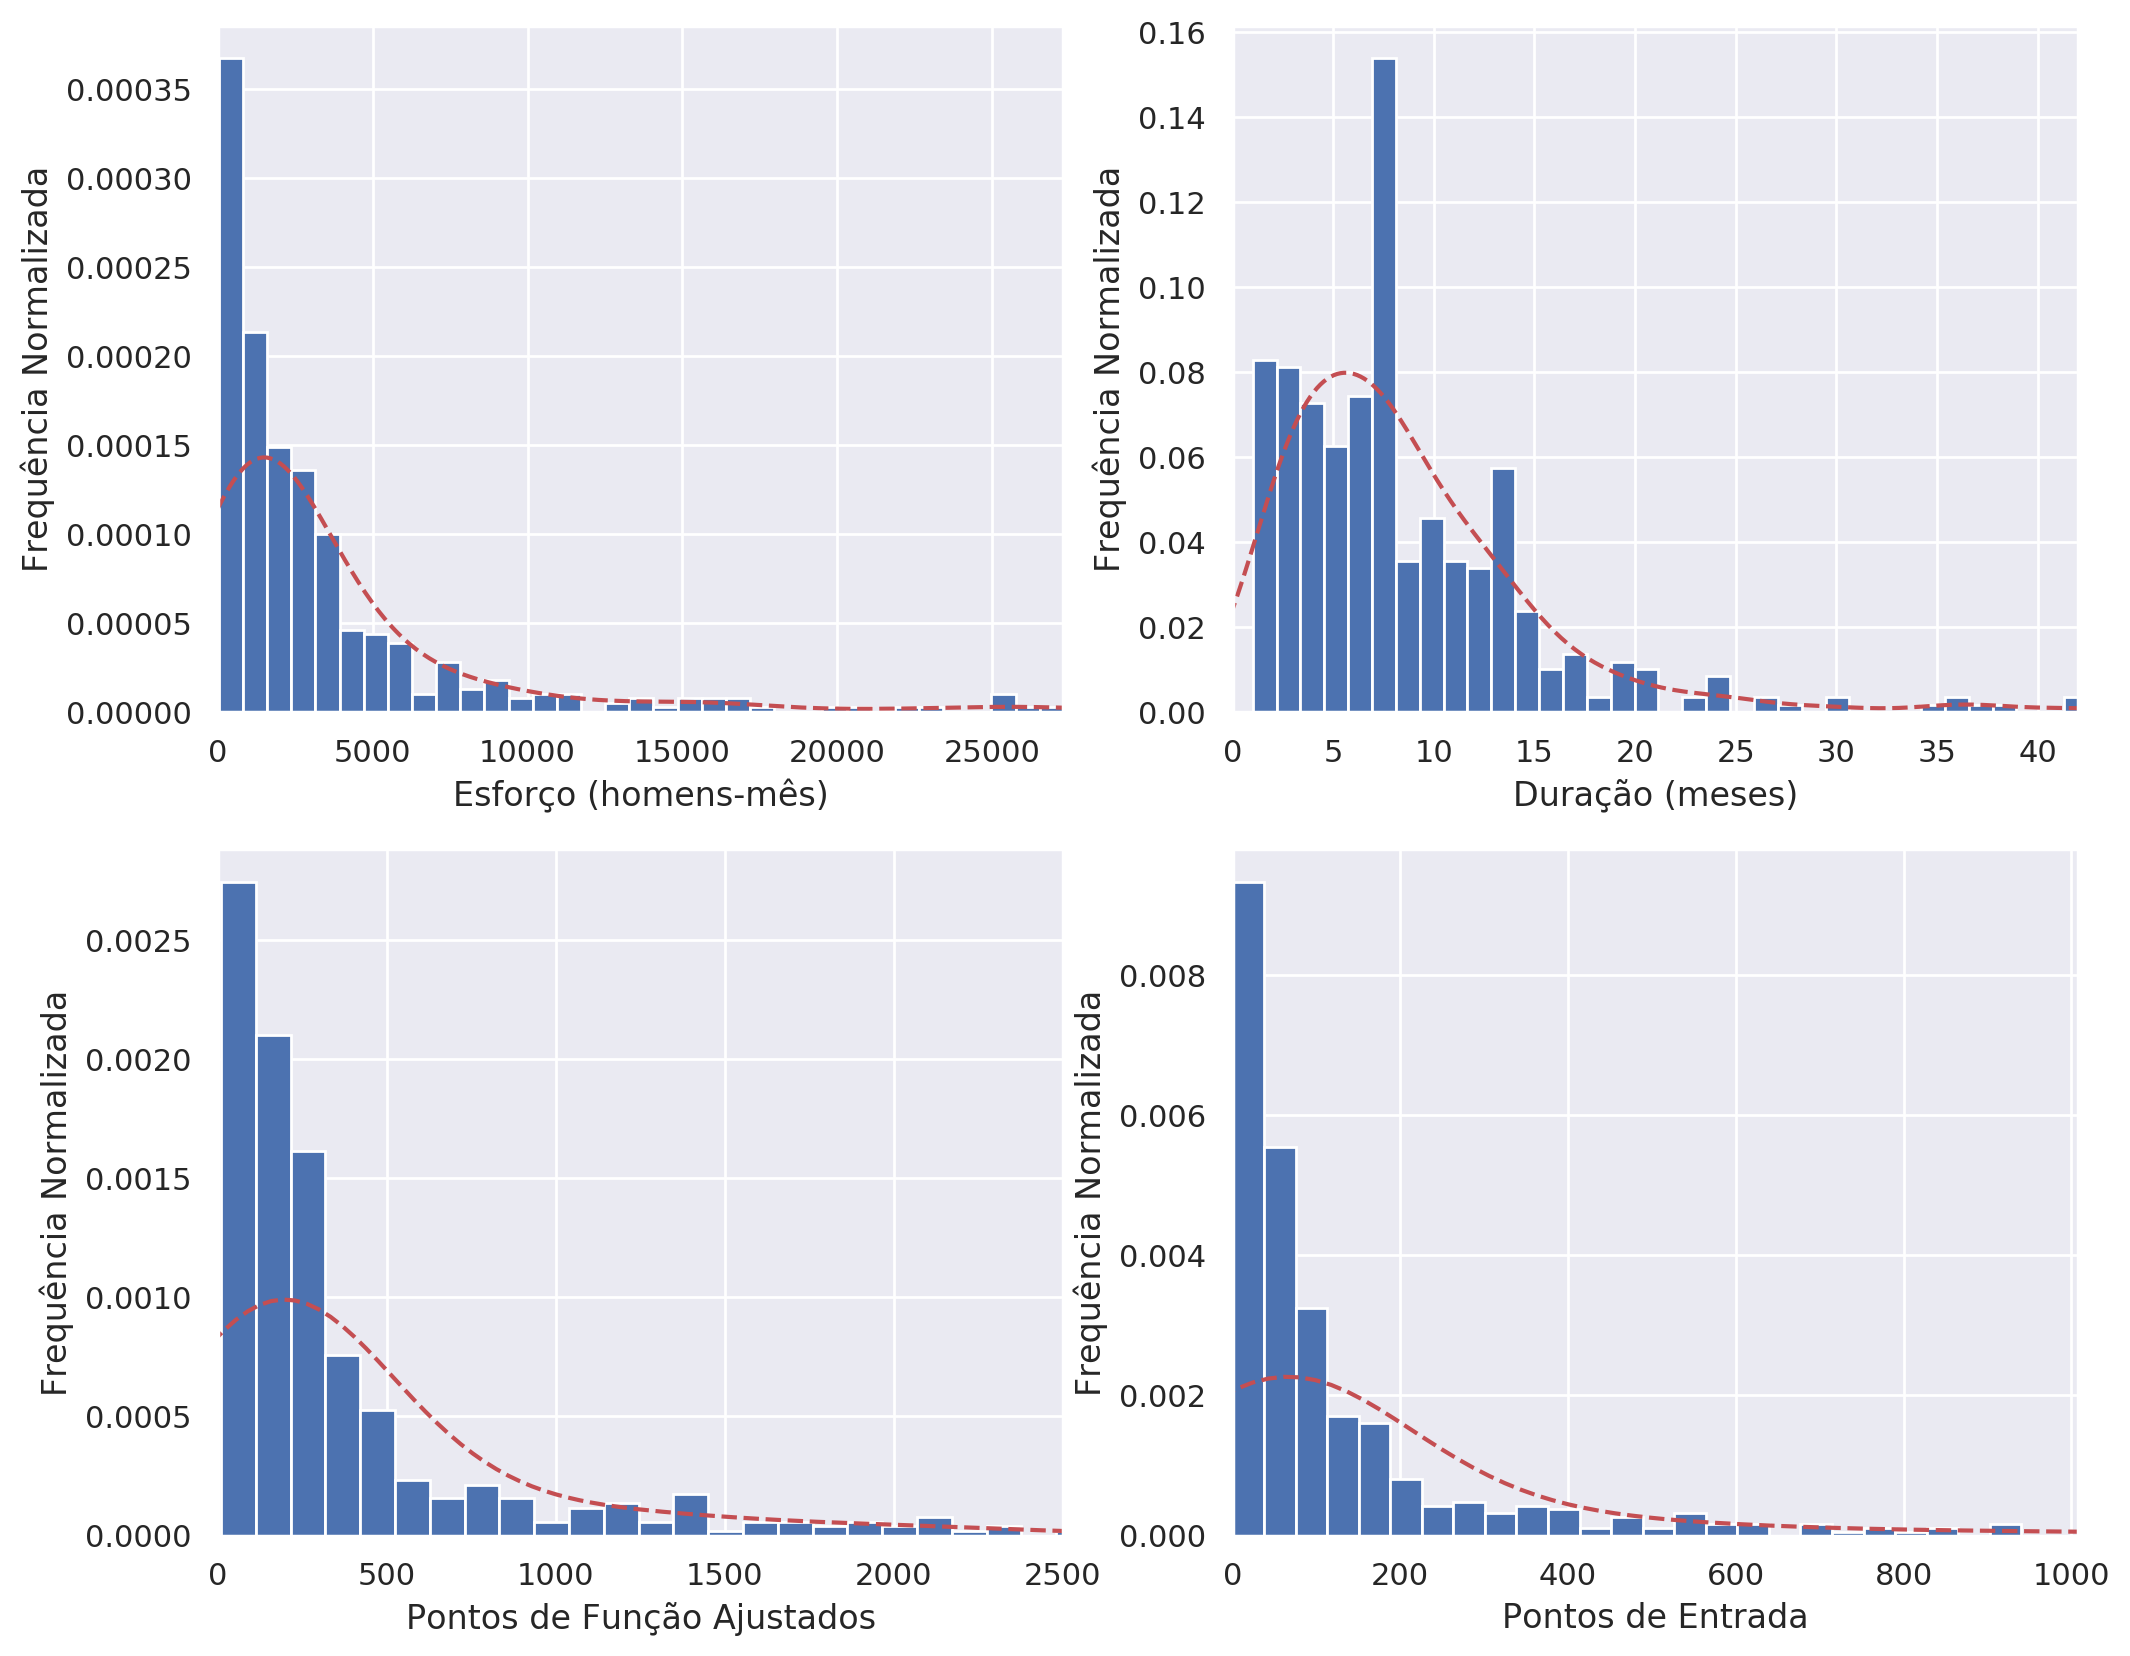

In [979]:
tabela = china_tabela

gs = matplotlib.gridspec.GridSpec(2, 2)
figura = plt.figure(figsize=(12,10), dpi=200)

ax = plt.subplot(gs[0, 0])
tabela.Effort.hist(bins=70, normed=True)
tabela.Effort.dropna().plot(kind='kde', xlim=(0,tabela.Effort.max()/2), style='r--')
plt.xlabel("Esforço (homens-mês)")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[1, 0])
tabela.AFP.hist(bins=170, normed=True)
tabela.AFP.dropna().plot(kind='kde', xlim=(0,tabela.AFP.max()/7), style='r--')
plt.xlabel("Pontos de Função Ajustados")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[0, 1])
tabela.Duration.hist(bins=70, normed=True)
tabela.Duration.dropna().plot(kind='kde', xlim=(0,tabela.Duration.max()/2), style='r--')
plt.xlabel("Duração (meses)")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[1, 1])
tabela.Input.hist(bins=250, normed=True)
tabela.Input.dropna().plot(kind='kde', xlim=(0,tabela.Input.median()*16), style='r--')
plt.xlabel("Pontos de Entrada")
plt.ylabel("Frequência Normalizada")


figura.savefig("resultados/dados/china.pdf", bbox_inches='tight')

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, 

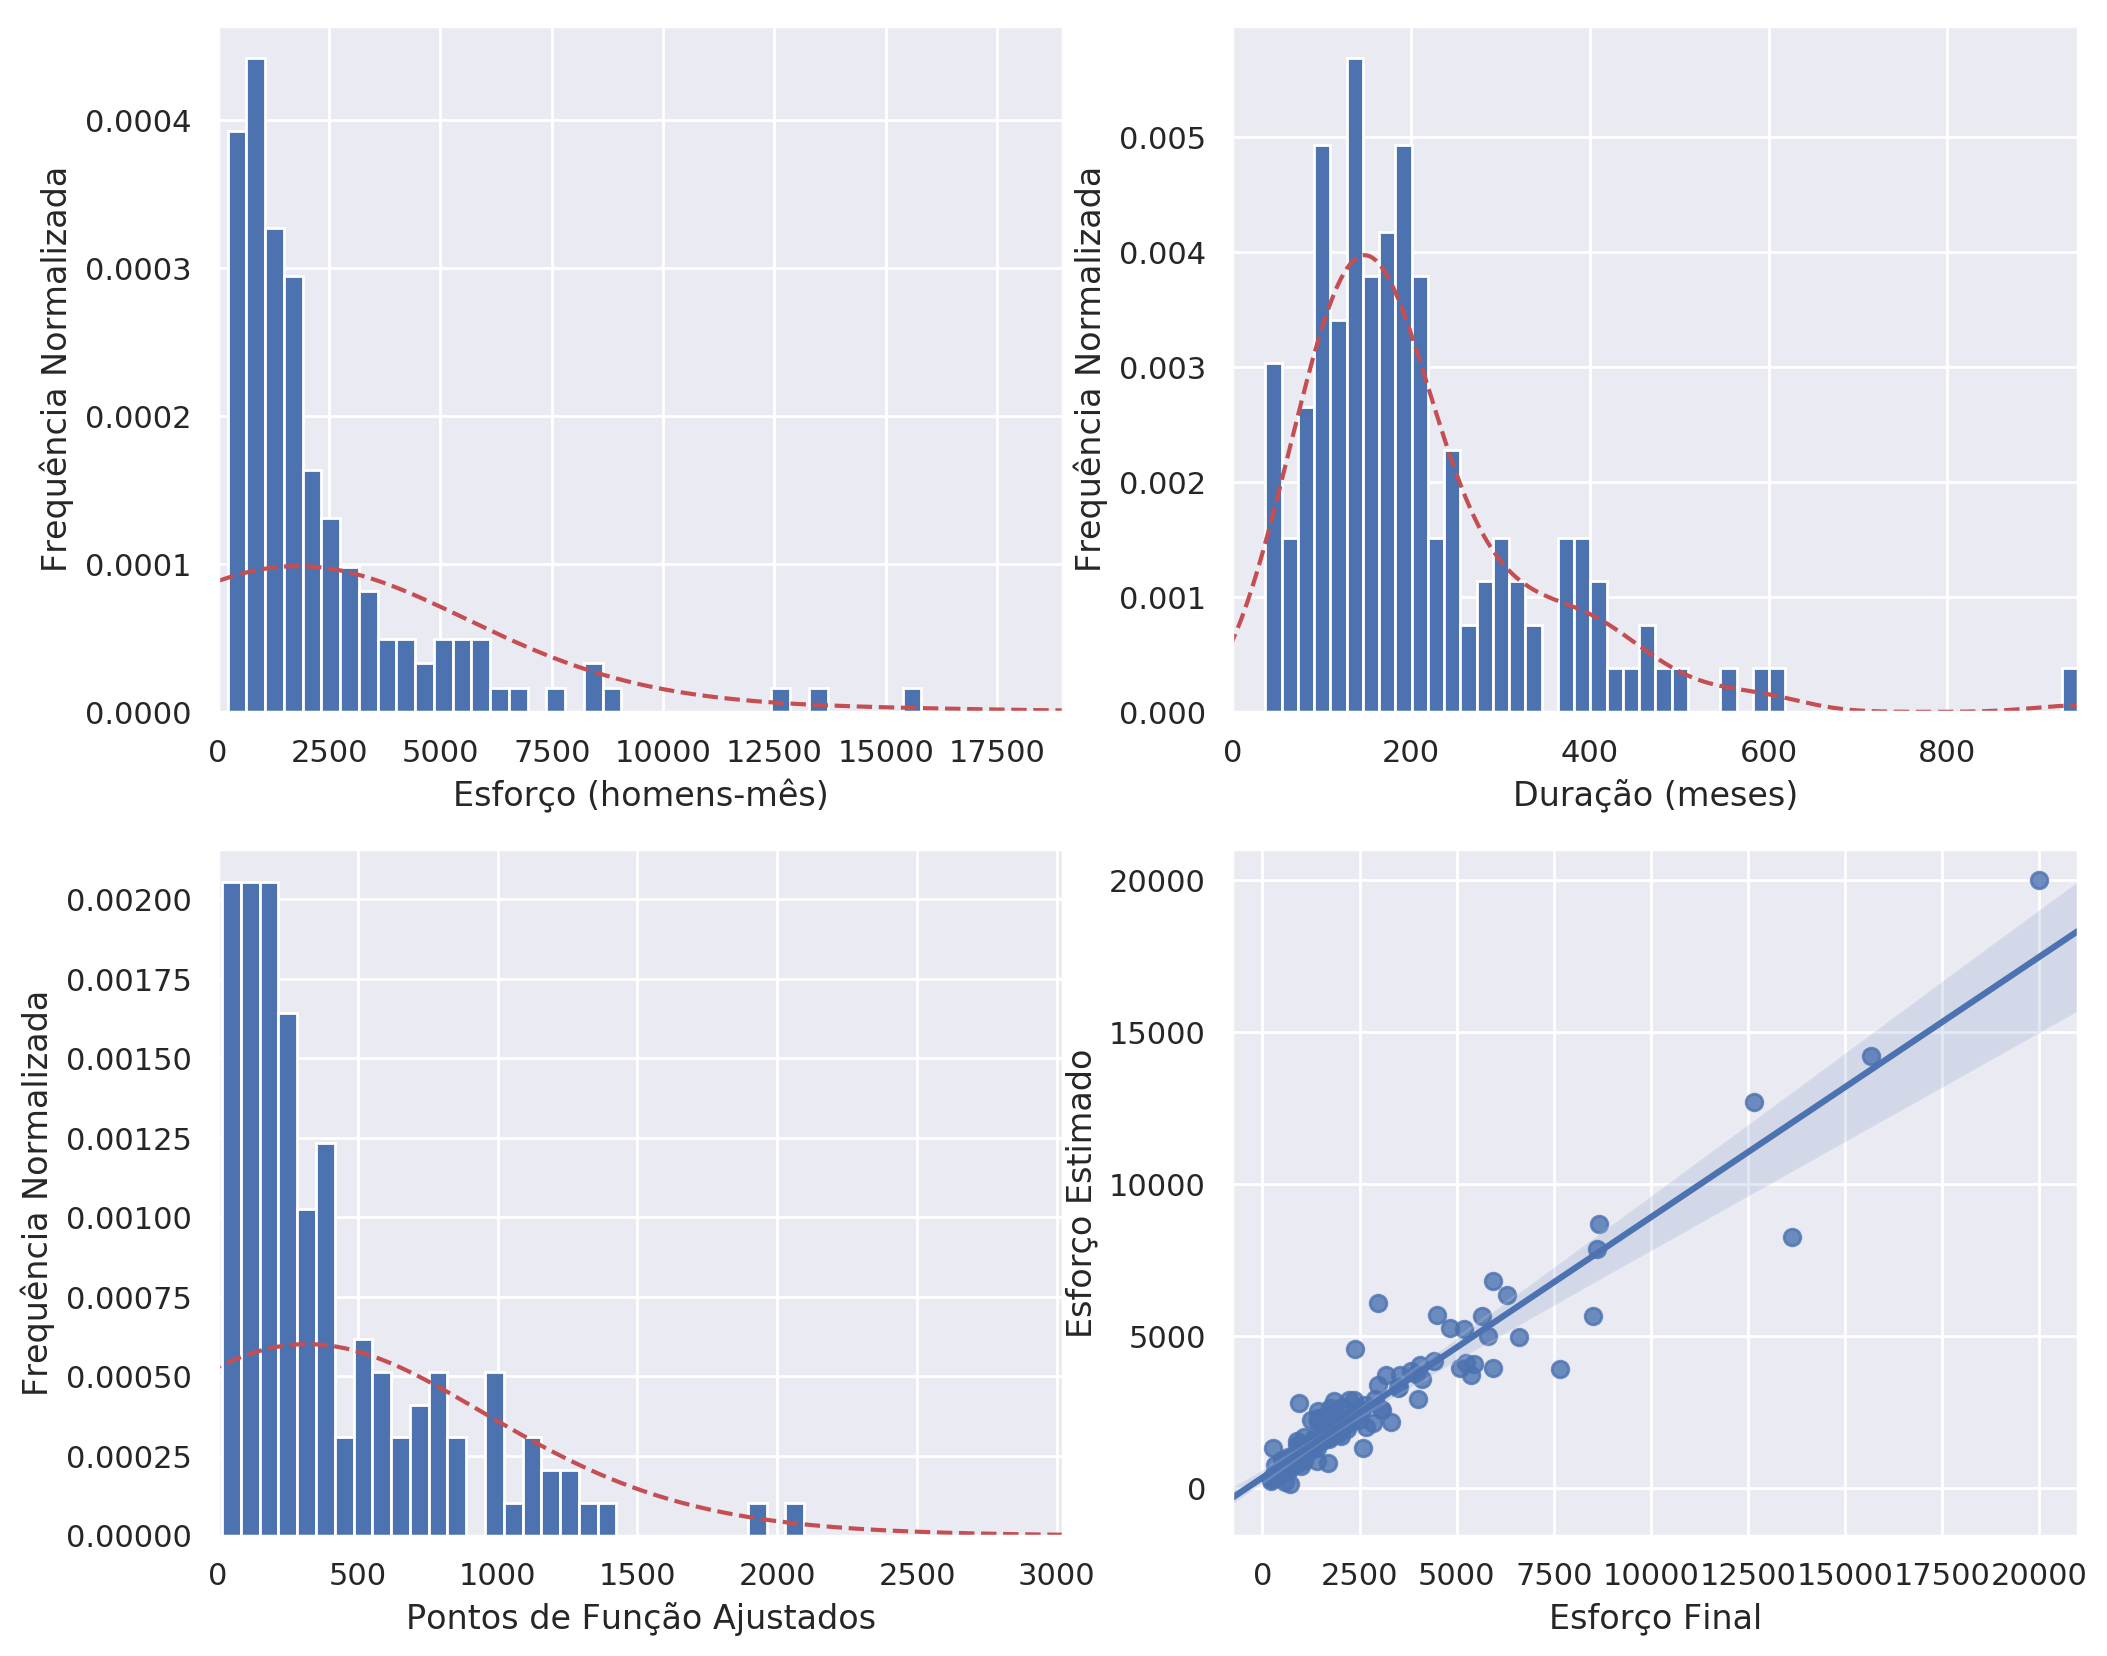

In [1000]:
tabela = dados_afp['kitchenham']

gs = matplotlib.gridspec.GridSpec(2, 2)
figura = plt.figure(figsize=(12,10), dpi=200)

ax = plt.subplot(gs[0, 0])
tabela.Effort.hist(bins=270, normed=True)
tabela.Effort.dropna().plot(kind='kde', xlim=(0,tabela.Effort.max()/6), style='r--')
plt.xlabel("Esforço (homens-mês)")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[1, 0])
tabela.AFP.hist(bins=270, normed=True)
tabela.AFP.dropna().plot(kind='kde', xlim=(0,tabela.AFP.max()/6), style='r--')
plt.xlabel("Pontos de Função Ajustados")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[0, 1])
tabela.Duration.hist(bins=50, normed=True)
tabela.Duration.dropna().plot(kind='kde', xlim=(0,tabela.Duration.max()), style='r--')
plt.xlabel("Duração (meses)")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[1, 1])
sns.regplot(tabela.Effort.values.clip(max=20000), tabela['First.estimate'].values.clip(max=20000))
plt.xlabel("Esforço Final")
plt.ylabel("Esforço Estimado")


figura.savefig("resultados/dados/kitchenham.pdf", bbox_inches='tight')

In [1001]:
dados_afp['desharnais']

ID TeamExp ManagerExp  YearEnd  Length  Effort  Transactions  Entities  \
0    1       1          4       85      12    5152           253        52   
1    2       0          0       86       4    5635           197       124   
2    3       4          4       85       1     805            40        60   
3    4       0          0       86       5    3829           200       119   
4    5       0          0       86       4    2149           140        94   
5    6       0          0       86       4    2821            97        89   
6    7       2          1       85       9    2569           119        42   
7    8       1          2       83      13    3913           186        52   
8    9       3          1       85      12    7854           172        88   
9   10       3          4       83       4    2422            78        38   
10  11       4          1       84      21    4067           167        99   
11  12       2          1       84      17    9051           146       112   
12  13       1          1       84       3    2282            33        72   
13  14       3          4       85       8    4172           162        61   
14  15       4          4       85       9    4977           223       121   
15  16       3          2       85       8    1617           119        48   
16  17       4          3       85       8    3192            57        43   
17  18       4          4       86      14    3437            68       316   
18  19       3          4       87      14    4494             9       386   
19  20       4          2       86       5     840            58        34   
20  21       4          4       86      12   14973           318       269   
21  22       2          4       85      18    5180            88       170   
22  23       2          4       86       5    5775           306       132   
23  24       4          1       87      20   10577           304        78   
24  25       1          4       86       8    3983            89       200   
25  26       4          1       85      14    3164            86       230   
26  27       2          0       86       6    3542            71       235   
27  28       3          1       85      14    4277           148       324   
28  29       4          4       85      16    7252           116       170   
29  30       4          1       85      14    3948           175       277   
..  ..     ...        ...      ...     ...     ...           ...       ...   
51  52       3          3       85       6    3136            86        49   
52  53       2          3       85      17   14434           221       121   
53  54       1          1       87      12    2583            61        96   
54  55       1          3       86      12    3647           132        89   
55  56       3          7       86      13    8232            45       387   
56  57       1          1       86      12    3276            55       112   
57  58       1          4       87       8    2723           124        52   
58  59       3          3       87       5    3472           120       126   
59  60       1          2       87       6    1575            47        32   
60  61       1          1       86      12    2926           126       107   
61  62       3          2       86       6    1876           101        45   
62  63       1          1       86       5    2520            78        99   
63  64       4          7       86      13    1603            69        74   
64  65       1          3       86       8    3626           194        97   
65  66       2          ?       87      10    6783           224       110   
66  67       2          4       87      15   11361           323       184   
67  68       1          3       86      10    1267            42        31   
68  69       1          2       87       5    2548            74        43   
69  70       3          4       87      10    1155           101        57   
70  71       0          4 

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


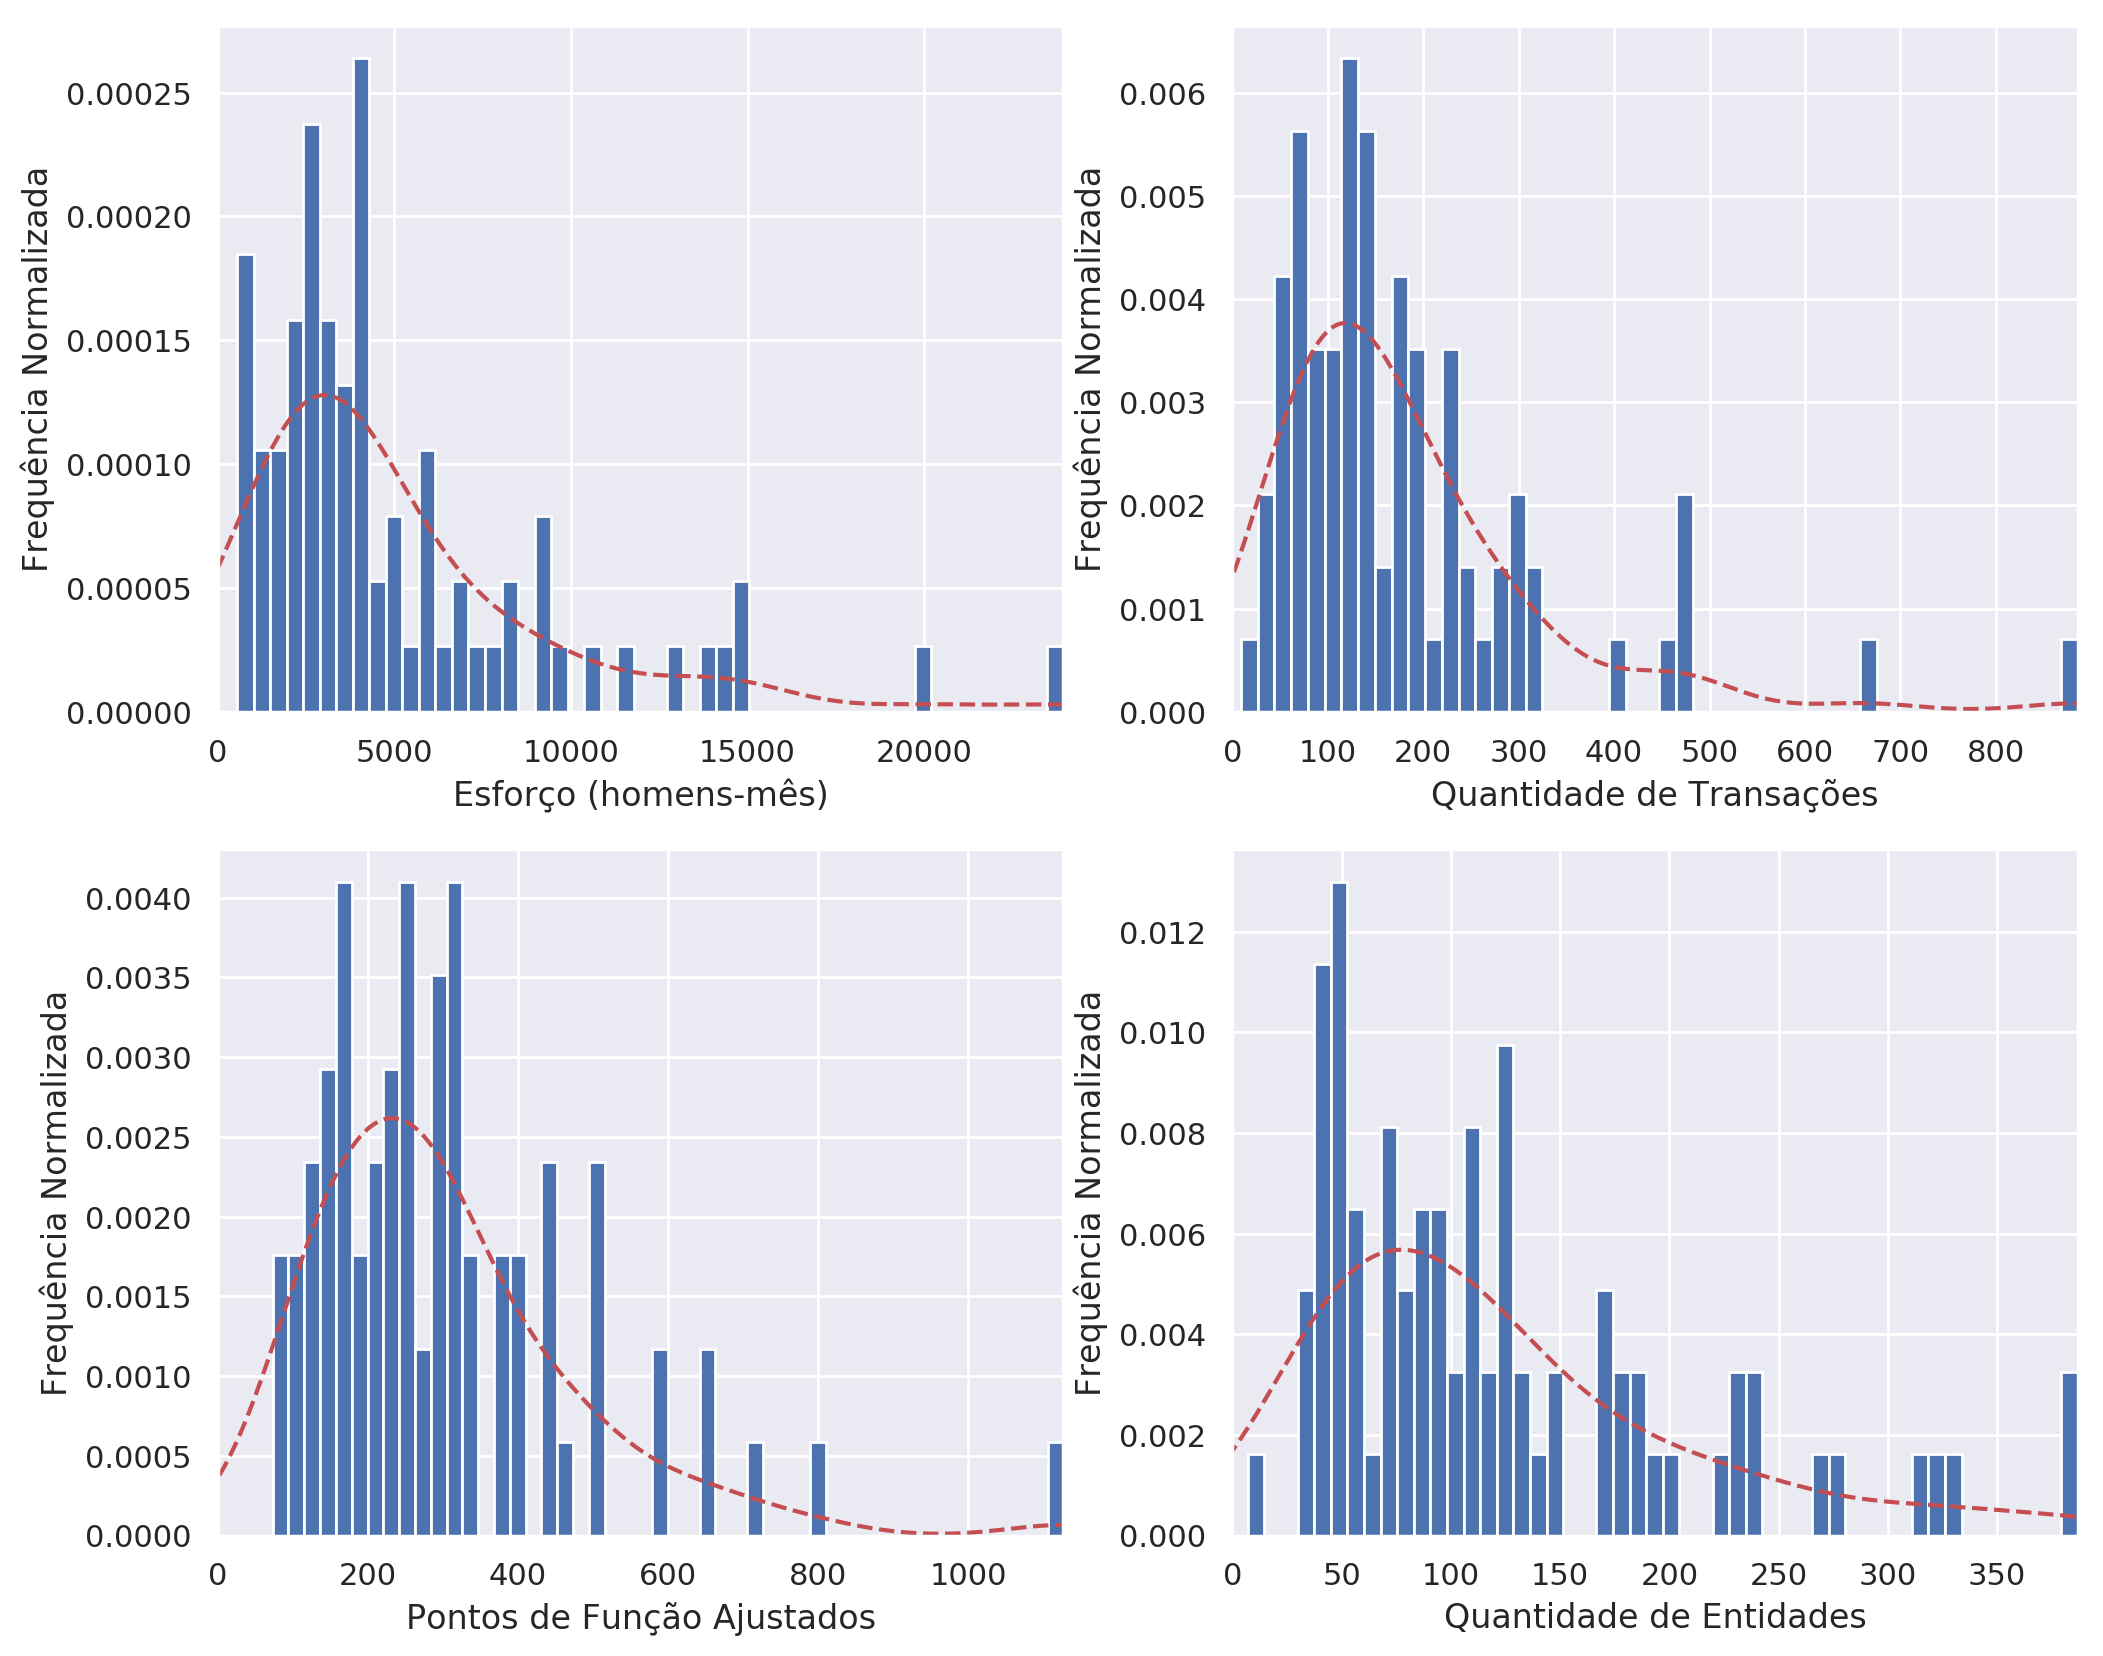

In [1006]:
tabela = dados_afp['desharnais']

gs = matplotlib.gridspec.GridSpec(2, 2)
figura = plt.figure(figsize=(12,10), dpi=200)

ax = plt.subplot(gs[0, 0])
tabela.Effort.hist(bins=50, normed=True)
tabela.Effort.dropna().plot(kind='kde', xlim=(0,tabela.Effort.max()), style='r--')
plt.xlabel("Esforço (homens-mês)")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[1, 0])
tabela.AFP.hist(bins=50, normed=True)
tabela.AFP.dropna().plot(kind='kde', xlim=(0,tabela.AFP.max()), style='r--')
plt.xlabel("Pontos de Função Ajustados")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[0, 1])
tabela.Transactions.hist(bins=50, normed=True)
tabela.Transactions.dropna().plot(kind='kde', xlim=(0,tabela.Transactions.max()), style='r--')
plt.xlabel("Quantidade de Transações")
plt.ylabel("Frequência Normalizada")

ax = plt.subplot(gs[1, 1])
tabela.Entities.hist(bins=50, normed=True)
tabela.Entities.dropna().plot(kind='kde', xlim=(0,tabela.Entities.max()), style='r--')
plt.xlabel("Quantidade de Entidades")
plt.ylabel("Frequência Normalizada")


figura.savefig("resultados/dados/desharnais.pdf", bbox_inches='tight')

In [17]:
afp_headers = ['Input', 'Output', 'Inquiry', 'File', 'AFP']
china_dados = china_tabela[['Effort'] + afp_headers].values
permuta_china = np.random.permutation(china_dados.shape[0])
china_dados_permutados = china_dados[permuta_china]
china_treino = china_dados_permutados[:int(china_dados.shape[0]*(1-validacao-teste))]
china_valida = china_dados_permutados[int(china_dados.shape[0]*(1-validacao-teste)):int(china_dados.shape[0]*(1-teste))]
china_teste = china_dados_permutados[int(china_dados.shape[0]*(1-teste)):]

In [39]:
def constroi_modelo_afp_completo(dim_entrada, dim_inicial, dim_intermediaria, dim_final):
    entrada = keras.layers.Input(shape=(dim_entrada,), dtype='float32', name='entrada_afp')
    camada = keras.layers.Dense(dim_inicial, activation='relu', name='relu_inicial')(entrada)
    #camada = keras.layers.Dropout(0.2)(camada)
    camada = keras.layers.Dense(dim_intermediaria, activation='relu', name='relu_media')(camada)
    camada = keras.layers.Dropout(0.2, name='drop_media')(camada)
    camada = keras.layers.Dense(dim_final, activation='relu', name='relu_final')(camada)
    camada = keras.layers.Dropout(0.3, name='drop_final')(camada)
    saida = keras.layers.Dense(1, activation='relu', name='saida_afp')(camada)
    return keras.models.Model(inputs=entrada, outputs=saida)

modelo_afp = constroi_modelo_afp_completo(len(afp_headers), 10, 20, 5)
modelo_afp.compile(loss='mse',optimizer='adam')
modelo_afp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada_afp (InputLayer)     (None, 5)                 0         
_________________________________________________________________
relu_inicial (Dense)         (None, 10)                60        
_________________________________________________________________
relu_media (Dense)           (None, 20)                220       
_________________________________________________________________
drop_media (Dropout)         (None, 20)                0         
_________________________________________________________________
relu_final (Dense)           (None, 5)                 105       
_________________________________________________________________
drop_final (Dropout)         (None, 5)                 0         
_________________________________________________________________
saida_afp (Dense)            (None, 1)                 6         
Total para

In [49]:
modelo_afp.set_weights([k + np.random.uniform(size=k.shape, high=0.4)-0.1 for k in modelo_afp.get_weights()])

In [50]:
historicos_afpp = []

In [51]:
parada_rapida = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min', restore_best_weights=True)
historico_afpp = modelo_afp.fit(china_treino[:,1:], china_treino[:,0], validation_data=(china_valida[:,1:], china_valida[:,0]), epochs=1000, verbose=0, callbacks=[parada_rapida])

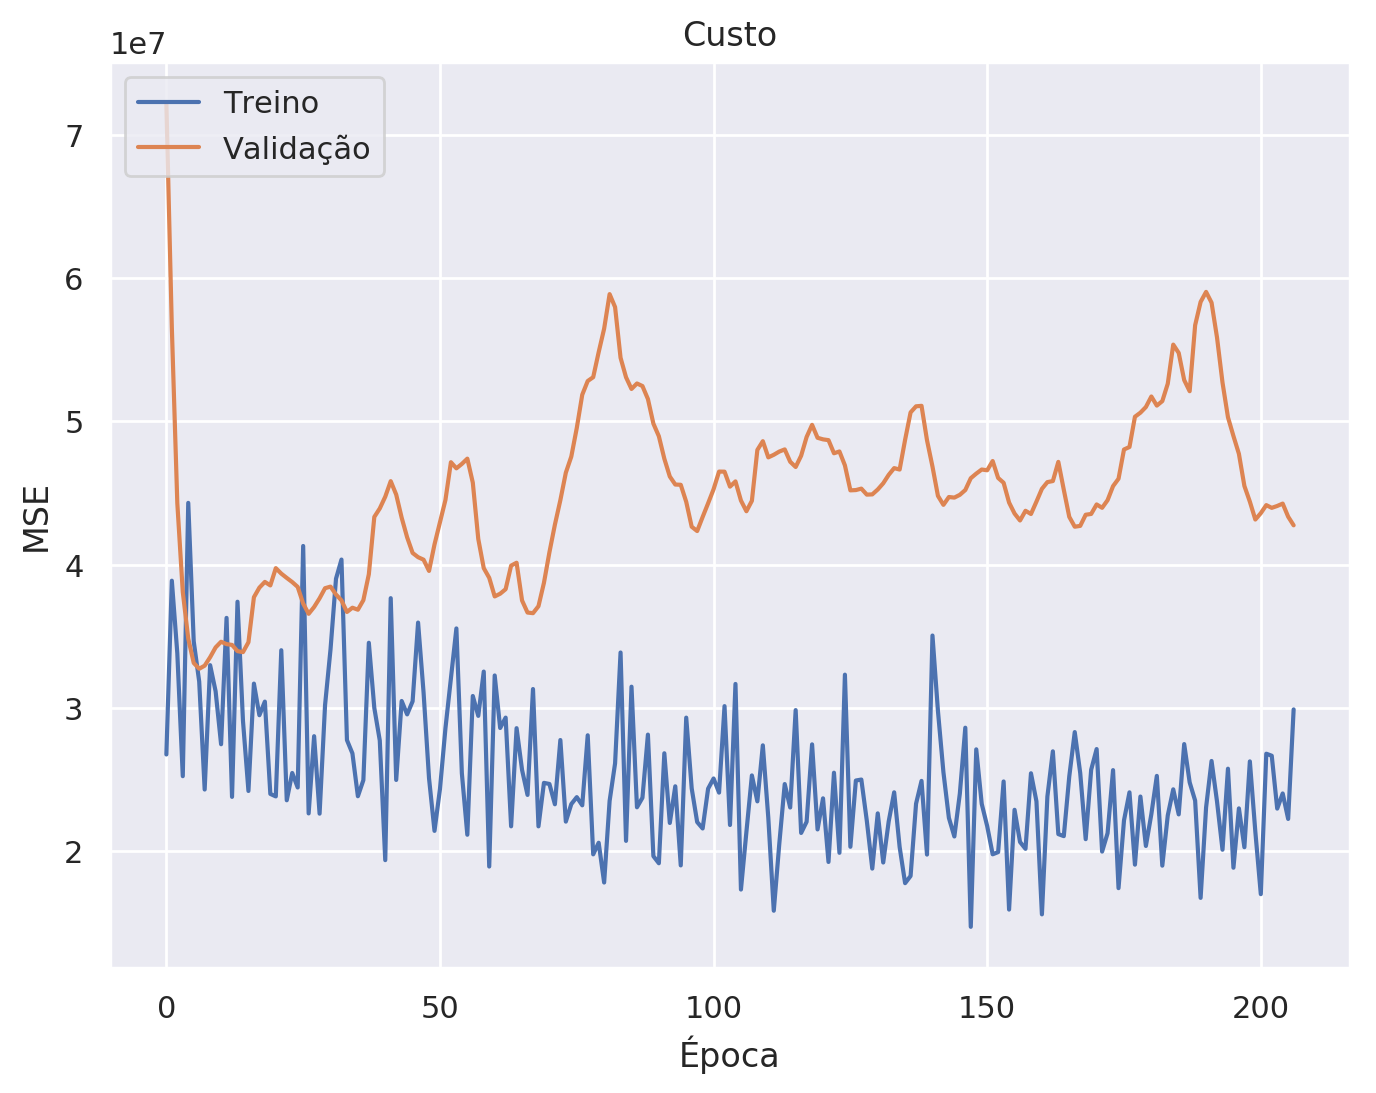

In [52]:
historicos_afpp.append(historico_afpp)
figura = plt.figure(figsize=(8,6), dpi=200)
plt.plot(historico_afpp.history['loss'])
plt.plot(historico_afpp.history['val_loss'])
plt.title('Custo')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
#figura.savefig("resultados/figuras/treino-afp.pdf", bbox_inches='tight')

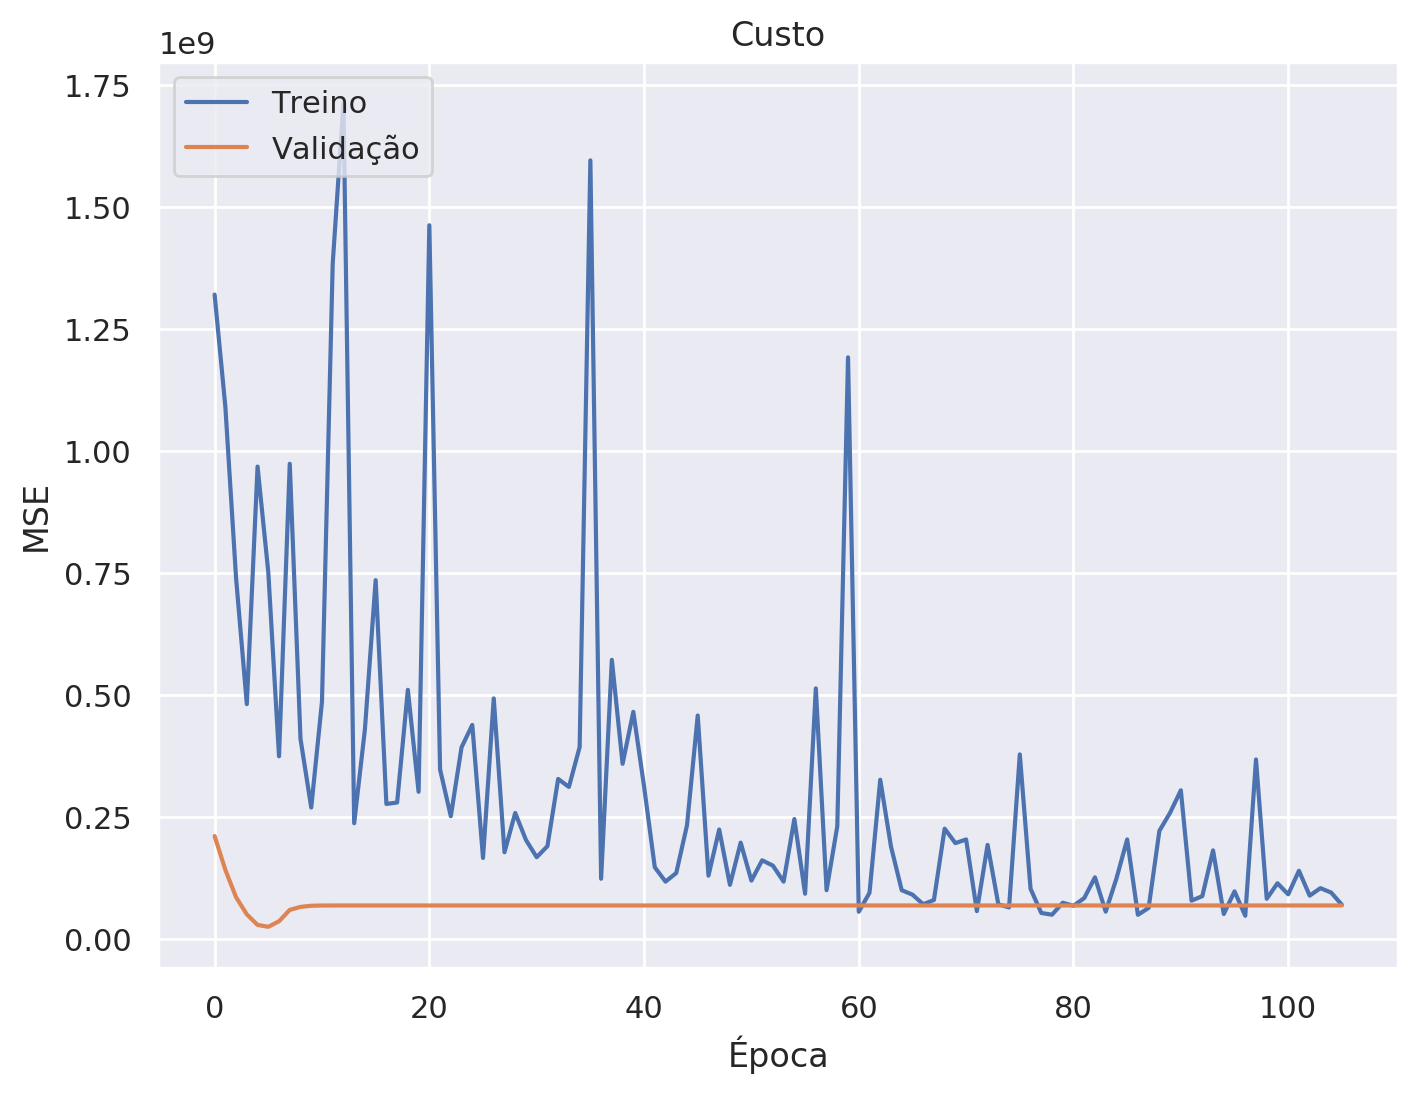

In [845]:
figura = plt.figure(figsize=(8,6), dpi=200)
plt.plot(historicos_afpp[-1].history['loss'])
plt.plot(historicos_afpp[-1].history['val_loss'])
plt.title('Custo')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
figura.savefig("resultados/figuras/treino-afp.pdf", bbox_inches='tight')

In [688]:
np.sqrt(min(historico_afpp.history['val_loss']))

5011.129363061119

In [691]:
np.sqrt(np.var(china_valida[:,0]))

7249.539074761159

## Refinamento da contagem AFP

In [23]:
ccapf = pd.read_csv('dados/afp-final.csv')
ccapf[['detalhada', 'indicativa', 'ALI baixa', 'AIE baixa']]

detalhada  indicativa  ALI baixa  AIE baixa
0      407.00         695         19          2
1     1389.00        2415         69          0
2      183.00         120          3          1
3     1069.00        1090         29          5
4       98.00         140          3          0
5      194.60         210          5          0
6      196.00         140          3          0
7      112.00         175          4          0
8      723.00         560         16          0
9      169.00         135          3          2
10     727.00         595         17          0
11     387.75         140          2          0

In [902]:
print(ccapf.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrrrrrrr}
\toprule
 Projeto &  detalhada &  indicativa &  ALI baixa &  ALI media &  ALI alta &  AIE baixa &  AIE media &  AIE alta &  EE baixa &  EE media &  EE alta &  SE baixa &  SE media &  SE alta &  CE baixa &  CE media &  CE alta \\
\midrule
       1 &     407.00 &         695 &         19 &          0 &         0 &          2 &          0 &         0 &        29 &         6 &        6 &         0 &         2 &        2 &        13 &         9 &        3 \\
       2 &    1389.00 &        2415 &         69 &          0 &         0 &          0 &          0 &         0 &         0 &       114 &        0 &         0 &        70 &        0 &         0 &        25 &        0 \\
       3 &     183.00 &         120 &          3 &          0 &         0 &          1 &          0 &         0 &         9 &         1 &        8 &         4 &         5 &        3 &         2 &         1 &        1 \\
       4 &    1069.00 &        1090 &         29 &          0 &   

In [24]:
ccav = np.zeros((len(ccapf), 4))
ccav[:, :2] = ccapf[['detalhada', 'indicativa']].values
ccav[:, 2] = np.sum(ccapf[[k for k in ccapf.columns if k.find('ALI') > -1]].values, axis=1)
ccav[:, 3] = np.sum(ccapf[[k for k in ccapf.columns if k.find('AIE') > -1]].values, axis=1)
ccav

array([[4.0700e+02, 6.9500e+02, 1.9000e+01, 2.0000e+00],
       [1.3890e+03, 2.4150e+03, 6.9000e+01, 0.0000e+00],
       [1.8300e+02, 1.2000e+02, 3.0000e+00, 1.0000e+00],
       [1.0690e+03, 1.0900e+03, 2.9000e+01, 5.0000e+00],
       [9.8000e+01, 1.4000e+02, 4.0000e+00, 0.0000e+00],
       [1.9460e+02, 2.1000e+02, 6.0000e+00, 0.0000e+00],
       [1.9600e+02, 1.4000e+02, 4.0000e+00, 0.0000e+00],
       [1.1200e+02, 1.7500e+02, 5.0000e+00, 0.0000e+00],
       [7.2300e+02, 5.6000e+02, 1.6000e+01, 0.0000e+00],
       [1.6900e+02, 1.3500e+02, 3.0000e+00, 2.0000e+00],
       [7.2700e+02, 5.9500e+02, 1.7000e+01, 0.0000e+00],
       [3.8775e+02, 1.4000e+02, 4.0000e+00, 0.0000e+00]])

In [25]:
ccap = np.random.permutation(ccav.shape[0])
ccavp = ccav[ccap]
ccavpt = ccavp[:7]
ccavpv = ccavp[7:]

In [26]:
def constroi_modelo_cca(dim_entrada, dim_inicial, dim_intermediaria, dim_final):
    entrada = keras.layers.Input(shape=(dim_entrada,), dtype='float32', name='entrada_cca')
    camada = keras.layers.Dense(dim_inicial, activation='relu')(entrada)
    camada = keras.layers.Dropout(0.2)(camada)
    camada = keras.layers.Dense(dim_intermediaria, activation='relu')(camada)
    camada = keras.layers.Dropout(0.2)(camada)
    camada = keras.layers.Dense(dim_final, activation='relu')(camada)
    camada = keras.layers.Dropout(0.2)(camada)
    saida = keras.layers.Dense(1, activation='relu', name='saida_cca')(camada)
    return keras.models.Model(inputs=entrada, outputs=saida)

modelo_cca = constroi_modelo_cca(ccav.shape[1]-1, 7, 11, 5)
modelo_cca.compile(loss='mse',optimizer='adam')
modelo_cca.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada_cca (InputLayer)     (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 28        
_________________________________________________________________
dropout_3 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 11)                88        
_________________________________________________________________
dropout_4 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 60        
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
__________

In [27]:
modelo_cca.set_weights([np.random.uniform(size=k.shape, high=0.17) for k in modelo_cca.get_weights()])

In [28]:
hist_cca = modelo_cca.fit(ccavpt[:,1:], ccavpt[:,0], validation_data=(ccavpv[:,1:],ccavpv[:,0]), epochs=250)

Train on 7 samples, validate on 5 samples
Epoch 1/250
7/7 [==============================] - 0s 187us/step - loss: 283532.0312 - val_loss: 441769.9375
Epoch 2/250
7/7 [==============================] - 0s 161us/step - loss: 291387.6562 - val_loss: 440631.0625
Epoch 3/250
7/7 [==============================] - 0s 149us/step - loss: 284251.9375 - val_loss: 439459.4375
Epoch 4/250
7/7 [==============================] - 0s 155us/step - loss: 285057.8438 - val_loss: 438310.0625
Epoch 5/250
7/7 [==============================] - 0s 185us/step - loss: 280912.5938 - val_loss: 437124.5000
Epoch 6/250
7/7 [==============================] - 0s 159us/step - loss: 267853.0938 - val_loss: 435884.4375
Epoch 7/250
7/7 [==============================] - 0s 165us/step - loss: 288175.8750 - val_loss: 434649.0000
Epoch 8/250
7/7 [==============================] - 0s 183us/step - loss: 293448.0625 - val_loss: 433428.1875
Epoch 9/250
7/7 [==============================] - 0s 179us/step - loss: 283032.7500 -

Epoch 76/250
7/7 [==============================] - 0s 148us/step - loss: 27239.2188 - val_loss: 217342.9688
Epoch 77/250
7/7 [==============================] - 0s 149us/step - loss: 59876.9414 - val_loss: 213224.1719
Epoch 78/250
7/7 [==============================] - 0s 148us/step - loss: 64899.0312 - val_loss: 209040.5469
Epoch 79/250
7/7 [==============================] - 0s 149us/step - loss: 61898.8320 - val_loss: 204837.0156
Epoch 80/250
7/7 [==============================] - 0s 148us/step - loss: 52957.4492 - val_loss: 200594.5781
Epoch 81/250
7/7 [==============================] - 0s 148us/step - loss: 77893.7969 - val_loss: 196288.5312
Epoch 82/250
7/7 [==============================] - 0s 158us/step - loss: 52866.7422 - val_loss: 191976.5469
Epoch 83/250
7/7 [==============================] - 0s 150us/step - loss: 66657.1172 - val_loss: 187608.2031
Epoch 84/250
7/7 [==============================] - 0s 156us/step - loss: 64663.2852 - val_loss: 183211.3906
Epoch 85/250
7/7 [=

Epoch 151/250
7/7 [==============================] - 0s 247us/step - loss: 42046.7109 - val_loss: 138185.5312
Epoch 152/250
7/7 [==============================] - 0s 232us/step - loss: 24613.0957 - val_loss: 136718.4219
Epoch 153/250
7/7 [==============================] - 0s 234us/step - loss: 24689.6152 - val_loss: 135238.3906
Epoch 154/250
7/7 [==============================] - 0s 235us/step - loss: 43527.1016 - val_loss: 133590.7031
Epoch 155/250
7/7 [==============================] - 0s 244us/step - loss: 42916.6055 - val_loss: 132537.2812
Epoch 156/250
7/7 [==============================] - 0s 236us/step - loss: 25262.4473 - val_loss: 131401.9688
Epoch 157/250
7/7 [==============================] - 0s 226us/step - loss: 29119.6152 - val_loss: 130102.3125
Epoch 158/250
7/7 [==============================] - 0s 238us/step - loss: 24016.5762 - val_loss: 128916.1406
Epoch 159/250
7/7 [==============================] - 0s 225us/step - loss: 40707.1055 - val_loss: 127530.9609
Epoch 160/

Epoch 226/250
7/7 [==============================] - 0s 207us/step - loss: 39574.6289 - val_loss: 91967.5000
Epoch 227/250
7/7 [==============================] - 0s 210us/step - loss: 71087.0703 - val_loss: 94946.7656
Epoch 228/250
7/7 [==============================] - 0s 199us/step - loss: 20692.1270 - val_loss: 97758.7969
Epoch 229/250
7/7 [==============================] - 0s 212us/step - loss: 114994.6016 - val_loss: 101377.3281
Epoch 230/250
7/7 [==============================] - 0s 205us/step - loss: 31975.9746 - val_loss: 104428.5000
Epoch 231/250
7/7 [==============================] - 0s 212us/step - loss: 45594.0547 - val_loss: 107674.3281
Epoch 232/250
7/7 [==============================] - 0s 201us/step - loss: 19209.9688 - val_loss: 110531.8984
Epoch 233/250
7/7 [==============================] - 0s 201us/step - loss: 22829.9902 - val_loss: 112918.6250
Epoch 234/250
7/7 [==============================] - 0s 199us/step - loss: 17823.6387 - val_loss: 115071.2969
Epoch 235/25

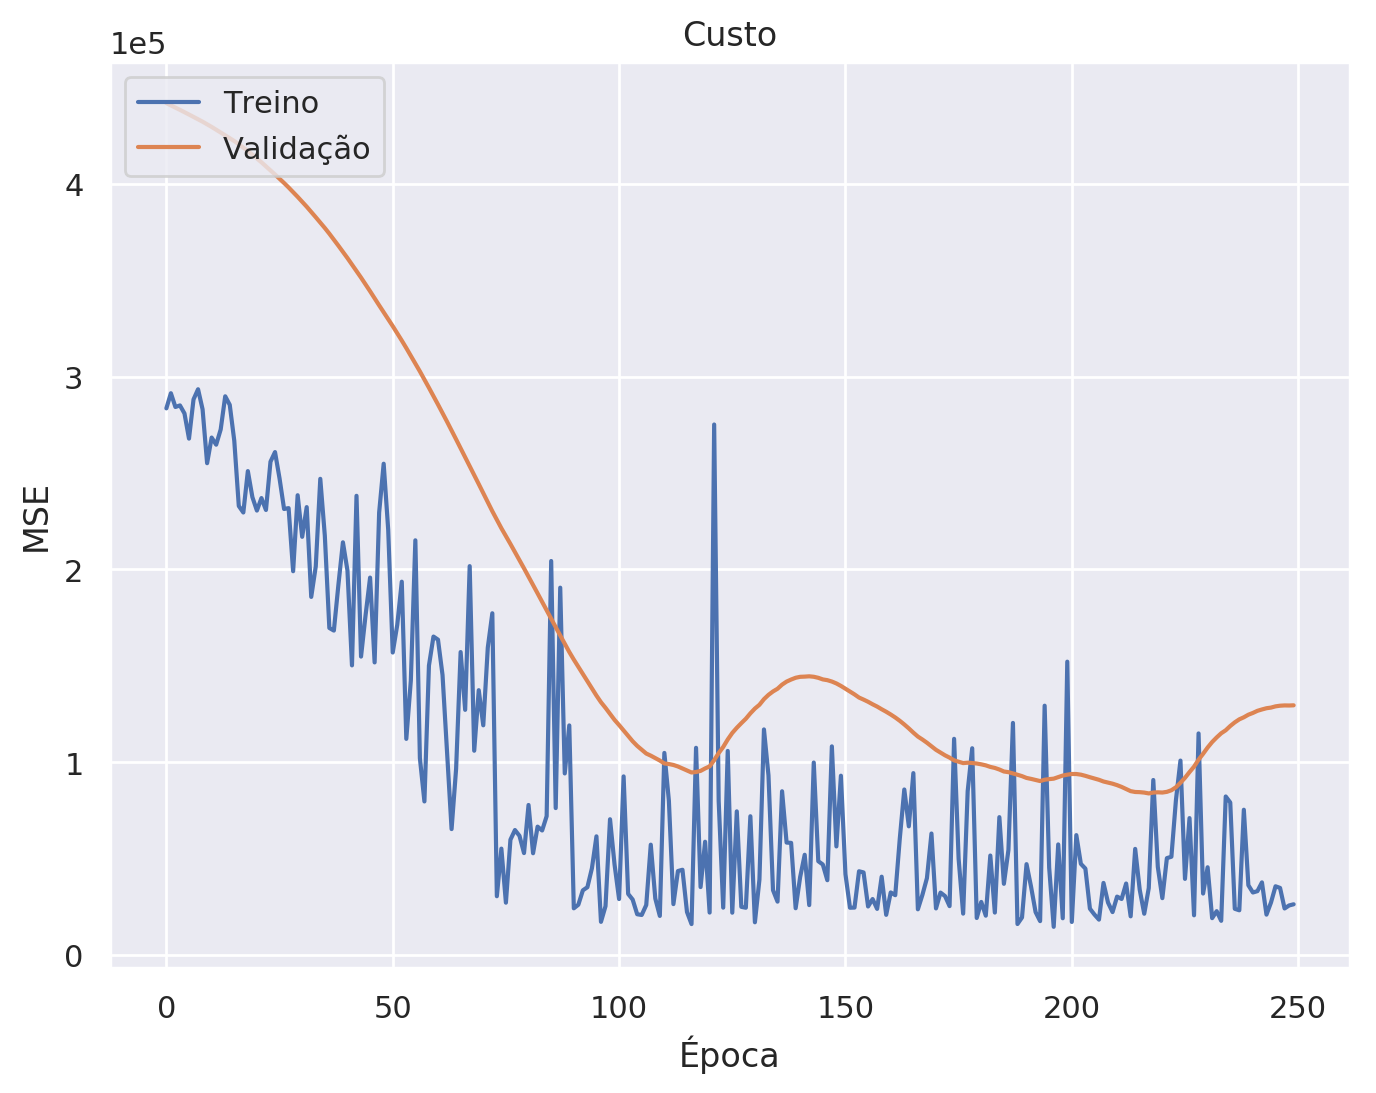

In [29]:
figura = plt.figure(figsize=(8,6), dpi=200)
plt.plot(hist_cca.history['loss'])
plt.plot(hist_cca.history['val_loss'])
plt.title('Custo')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
#figura.savefig("resultados/figuras/treino-cca.pdf", bbox_inches='tight')

## Modelo Híbrido AFP-KLOC Final

In [38]:
dados['cocomo_nasa2000'].columns

Index(['ID', 'Unusual Flag', 'Nasa60?', 'ProjectID', 'PARENT', 'ELEMENT',
       'Category', 'F or G', 'Center', 'Start Year', 'Language', 'New KLOC',
       'Reused KLOC', 'Modified KLOC', 'Logical EKLOC', 'Effort', 'Model',
       'PREC', 'FLEX', 'RESL', 'TEAM', 'PMAT', 'RELY', 'CPLX', 'DATA', 'RUSE',
       'TIME', 'STOR', 'PVOL', 'ACAP', 'PCAP', 'PCON', 'APEX', 'PLEX', 'LTEX',
       'TOOL', 'SCED', 'SITE', 'DOCU', 'Start Date', 'End Date',
       'Delivered Logical KLOC', 'Physical Delivered KLOC', 'Ported KLOC',
       '%DM', '%CM', '%IM', 'Actual Schedule', 'productivity per day', 'KLOC'],
      dtype='object')

### Preparação do conjunto de dados

Enriquecimento do conjunto de dados China a partir dos atributos COCOMO-II advindos de projetos NASA 2000 com uma quantidade semelhante de esforço.

In [30]:
colunas_china_aproveita = ['AFP', 'Input', 'Output', 'Inquiry', 'File', 'Interface', 'Added', 'Changed', 'Deleted', 'Effort']

In [31]:
def encontra_mais_proximo(vetor_crescente, valor):
    idx = np.searchsorted(vetor_crescente, valor, side="left")
    if idx > 0 and (idx == len(vetor_crescente) or math.fabs(valor - vetor_crescente[idx-1]) < math.fabs(valor - vetor_crescente[idx])):
        return idx-1
    else:
        return idx

In [32]:
tabela_cocomo_crescente = dados['cocomo_nasa2000'].sort_values('Effort')
valores_cocomo = formata_dados_tabela(tabela_cocomo_crescente, dim_entrada, params)
esforco_cocomo = tabela_cocomo_crescente.Effort.values

In [70]:
#dados_enriquecidos = np.zeros((dados_afp['china'].shape[0], valores_cocomo.shape[1] + len(colunas_china_aproveita)))
dados_enriquecidos = np.zeros((dados_afp['china'].shape[0], valores_cocomo.shape[1] + len(afp_headers) + 1))

In [72]:
#dados_enriquecidos[:, -len(colunas_china_aproveita):] = dados_afp['china'].loc[:, colunas_china_aproveita].values
dados_enriquecidos[:, -len(afp_headers)-1:] = dados_afp['china'].loc[:, afp_headers + ['Effort']].values
for i in range(dados_enriquecidos.shape[0]):
    idx = encontra_mais_proximo(esforco_cocomo, dados_enriquecidos[i, -1])
    dados_enriquecidos[i, :valores_cocomo.shape[1]] = valores_cocomo[idx, :]

In [73]:
permuta_de = np.random.permutation(dados_enriquecidos.shape[0])
dadosen_permutados = dados_enriquecidos[permuta_de]
dadosen_treino = dadosen_permutados[:int(dados_enriquecidos.shape[0]*(1-validacao-teste))]
dadosen_valida = dadosen_permutados[int(dados_enriquecidos.shape[0]*(1-validacao-teste)):int(dados_enriquecidos.shape[0]*(1-teste))]
dadosen_teste = dadosen_permutados[int(dados_enriquecidos.shape[0]*(1-teste)):]

### Modelo com pesos inicializados dos outros

In [ ]:
def constroi_modelo(dim_entrada, dim_inicial, dim_intermediaria):
    entrada = keras.layers.Input(shape=(dim_entrada,), dtype='float32', name='entrada')
    combina_linear = keras.layers.Dense(dim_inicial, name='combina_linear')(entrada)
    combina_log = AtivacaoLog(dim_intermediaria, name='combina_log')(combina_linear)
    recombina_relu = keras.layers.Dense(dim_intermediaria, name='combina_relu')(combina_linear)
    produto_interno = keras.layers.dot([combina_log, recombina_relu], axes=1, name='produto_interno')
    saida = keras.layers.Dense(1, activation='exponential', name='saida')(produto_interno)
    return keras.models.Model(inputs=entrada, outputs=saida)

def constroi_modelo_afp_completo(dim_entrada, dim_inicial, dim_intermediaria, dim_final):
    entrada = keras.layers.Input(shape=(dim_entrada,), dtype='float32', name='entrada_afp')
    camada = keras.layers.Dense(dim_inicial, activation='relu', name='relu_inicial')(entrada)
    #camada = keras.layers.Dropout(0.2)(camada)
    camada = keras.layers.Dense(dim_intermediaria, activation='relu', name='relu_media')(camada)
    camada = keras.layers.Dropout(0.2, name='drop_media')(camada)
    camada = keras.layers.Dense(dim_final, activation='relu', name='relu_final')(camada)
    camada = keras.layers.Dropout(0.3, name='drop_final')(camada)
    saida = keras.layers.Dense(1, activation='relu', name='saida_afp')(camada)
    return keras.models.Model(inputs=entrada, outputs=saida)

In [56]:
modelo_cocomo.get_layer('combina_linear') # combina_log combina_relu produto_interno
modelo_afp.get_layer('relu_inicial') # relu_media relu_final

In [57]:
modelo_cocomo.get_input_shape_at(0)

(None, 133)

In [88]:
modelo_cocomo.non_trainable_weights

[]

In [96]:
def controi_modelo_hibrido(modelo_cocomo, modelo_afp, lrelu1=10, lrelu2=4):
    camadas_cocomo = ['combina_linear', 'combina_log', 'combina_relu', 'produto_interno']
    camadas_afp = ['relu_inicial', 'relu_media', 'relu_final']
    entrada_cocomo = modelo_cocomo.get_layer('entrada').get_input_at(0)
    entrada_afp = modelo_afp.get_layer('entrada_afp').get_input_at(0)
    concatenacao = keras.layers.Concatenate(name='concatena')([modelo_afp.get_layer(k).get_output_at(0) for k in camadas_afp]
                                            + [modelo_cocomo.get_layer(k).get_output_at(0) for k in camadas_cocomo])
    lrelu_inicial = keras.layers.Dense(lrelu1, activation='relu', name='lrelu1')(concatenacao)
    lrelu_media = keras.layers.Dense(lrelu2, activation='relu', name='lrelu2')(lrelu_inicial)
    saida_final = keras.layers.Dense(1, name='saida_hibrida')(lrelu_media)
    return keras.models.Model(inputs=[entrada_cocomo, entrada_afp], outputs=saida_final)

modelo_hibrido = controi_modelo_hibrido(modelo_cocomo, modelo_afp)
modelo_hibrido.compile(loss='mse',optimizer='adam')
modelo_hibrido.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entrada_afp (InputLayer)        (None, 5)            0                                            
__________________________________________________________________________________________________
relu_inicial (Dense)            (None, 10)           60          entrada_afp[0][0]                
__________________________________________________________________________________________________
entrada (InputLayer)            (None, 133)          0                                            
__________________________________________________________________________________________________
relu_media (Dense)              (None, 20)           220         relu_inicial[0][0]               
__________________________________________________________________________________________________
combina_li

In [80]:
modelo_hibrido.get_weights()

[array([[ 0.5911549 ,  0.7800275 ,  0.3597578 , -0.20792802, -0.1250266 ,
         -0.39453456, -0.5903161 , -0.01178866,  0.7134001 ,  1.0853164 ],
        [ 0.940301  , -0.3638459 ,  0.24329825, -0.2900665 ,  0.88768137,
         -0.23233055, -0.04405687,  0.652031  , -0.37023494,  0.14682457],
        [ 0.17602973,  0.4019569 ,  0.8104186 , -0.0270823 , -0.36192358,
          0.1717354 ,  0.02896995,  0.61240387,  0.11706351,  0.21862608],
        [ 0.31262997,  0.37187433,  0.44692475,  0.7890295 ,  0.9654671 ,
          0.17076093, -0.13770314, -0.12053906, -0.37260213,  0.05952787],
        [ 0.6828756 ,  0.02834667,  0.11557909,  0.6398463 ,  0.703828  ,
         -0.52412933, -0.5257618 , -0.09382946, -0.40223846,  0.2412343 ]],
       dtype=float32),
 array([ 0.5691022 ,  0.50745326,  0.10673171,  0.57534623,  0.5125063 ,
        -0.02298787, -0.03423494,  0.08652148,  0.30444038,  0.2099912 ],
       dtype=float32),
 array([[ 0.41331768,  0.21629266, -0.20313838, -0.30027518, 

In [59]:
dim_entrada

133

In [63]:
modelo_cocomo.get_layer('entrada')

In [97]:
historicos_hibrido = []

In [98]:
parada_rapida = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min', restore_best_weights=True)
historico_hibrido = modelo_hibrido.fit([dadosen_treino[:,:dim_entrada], dadosen_treino[:, dim_entrada:-1]], dadosen_treino[:,-1], validation_data=([dadosen_valida[:,:dim_entrada], dadosen_valida[:, dim_entrada:-1]], dadosen_valida[:,-1]), epochs=1000, verbose=0, callbacks=[parada_rapida])

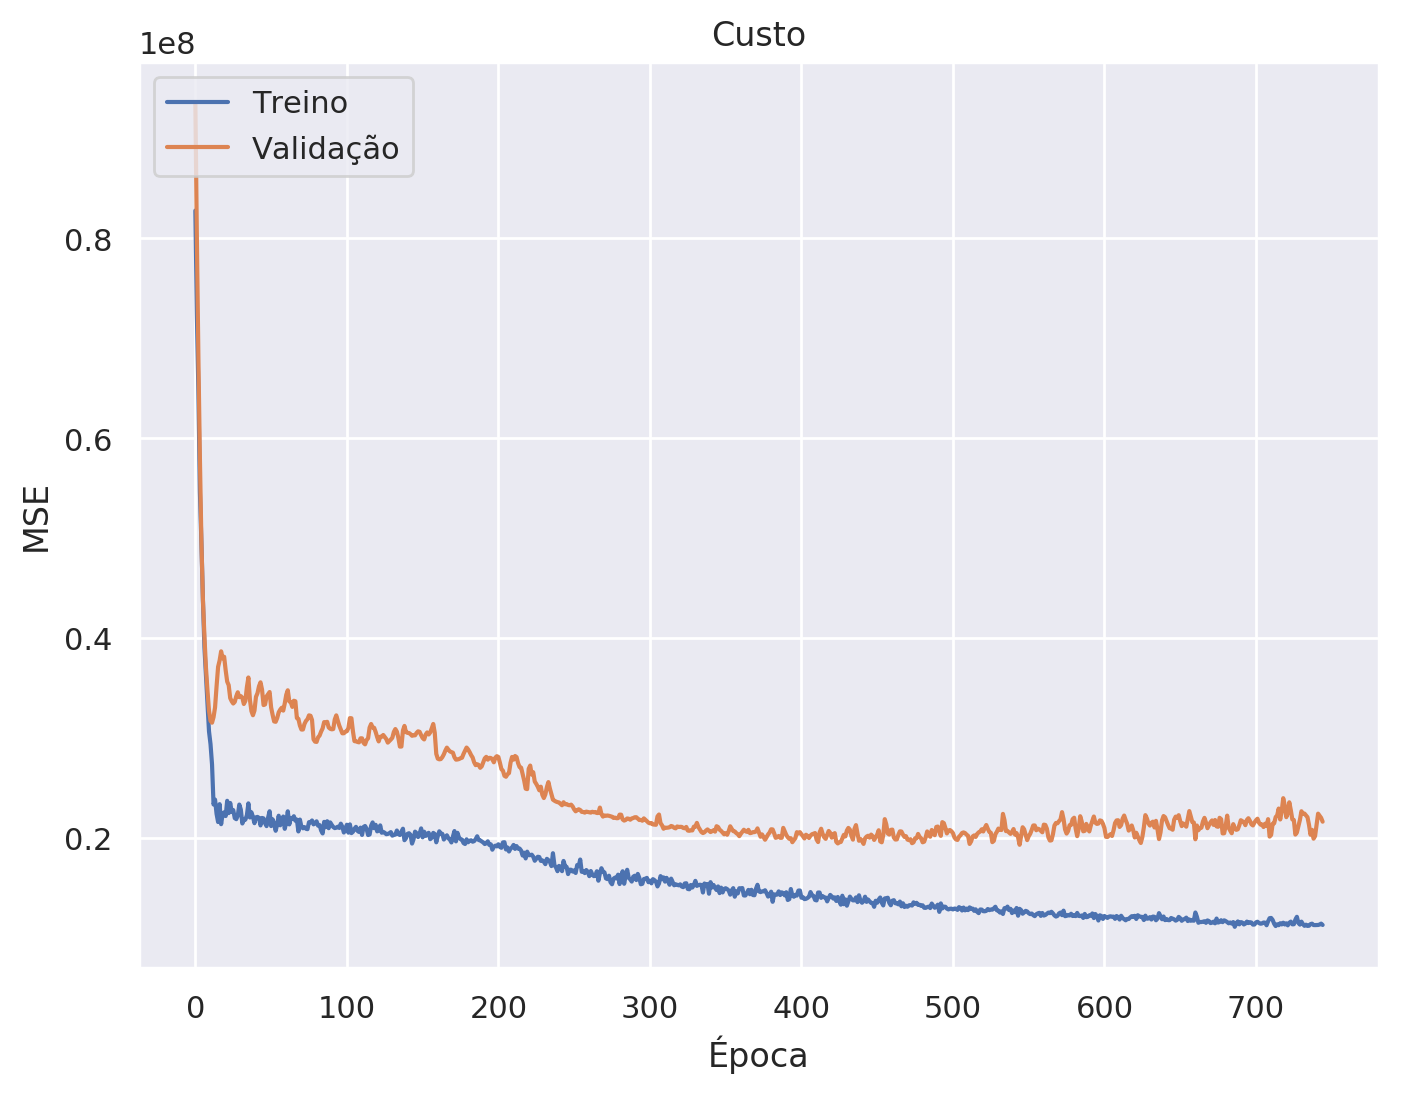

In [100]:
historicos_hibrido.append(historico_hibrido)
figura = plt.figure(figsize=(8,6), dpi=200)
plt.plot(historico_hibrido.history['loss'])
plt.plot(historico_hibrido.history['val_loss'])
plt.title('Custo')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
figura.savefig("resultados/figuras/treino-hibrido.pdf", bbox_inches='tight')